<a href="https://colab.research.google.com/github/pswietojanski/ojsp_adaptation_review_2020/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import pandas as pd
import gspread
import csv
import io
import os
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
import matplotlib.pyplot as plt
from IPython.display import display

In [ ]:
!pip install tikzplotlib
import tikzplotlib

#Data IO


In [4]:
def load_df_csv(fname):
    with open(fname, 'r') as f:
        data = pd.read_csv(f)
        return data

def load_from_csv():
    f1 = 'ojsp-meta-analysis - meta.csv'
    f2 = 'ojsp-meta-analysis - method2level.csv'
    f3 = 'ojsp-meta-analysis - defs.csv'
    df1 = load_df_csv(f1)
    df2 = load_df_csv(f2)
    df3 = load_df_csv(f3)
    return df1, df2, df3

def load_df_gsheet2():
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name(
         '/content/ojsp-sa-1592840444343-783932c34af3.json', scope)
    gc = gspread.authorize(credentials)
    ws = gc.open("ojsp-meta-analysis")
    meta = pd.DataFrame(ws.worksheet("meta").get_all_records())
    method2level = pd.DataFrame(ws.worksheet("method2level").get_all_records())
    defs = pd.DataFrame(ws.worksheet("defs").get_all_records())
    dataset2stats = pd.DataFrame(ws.worksheet("dataset2stats").get_all_records())
    
    meta = meta.merge(method2level, how='left', left_on='Method1', right_on='Method',
           suffixes=('_x', '_y'), copy=True, indicator=False, validate='many_to_one')

    meta = meta.merge(dataset2stats, how='left', left_on='Train', right_on='Dataset',
             suffixes=('_x', '_y'), copy=True, indicator=False, validate='many_to_one')

    return meta, dataset2stats

def filter_data(data):
    #remove entries with empty WERs
    s1 = data.shape
    data['WERR'].replace('', np.nan, inplace=True)
    data = data.dropna(subset=['WERR'])
    s2 = data.shape
    print (f"Before {s1} / {s2} after filtering on empty WERR")
    #remove entries explicitly annotated to not use in aggregation
    s1 = data.shape
    data = data[data['use_in_agg'] == 'yes']
    s2 = data.shape
    print (f"Before {s1} / {s2} after filtering on use in aggregation")

    #change yes/no fields to more descriptive ones
    data.loc[(data.sat == 'yes'), 'sat'] = 'SAT'
    data.loc[(data.sat == 'no'), 'sat'] = 'Test-only'
    data.loc[(data.Unsup == 'yes'), 'Unsup'] = 'Unsupervised'
    data.loc[(data.Unsup == 'no'), 'Unsup'] = 'Supervised'
    data.loc[(data.Public == 'yes'), 'Public'] = 'Public'
    data.loc[(data.Public == 'no'), 'Public'] = 'Proprietary'

    return data

def filter_dataset_for_paper(data, annot_dset_name=True):
    #remove entries explicitly annotated to not use in aggregation
    s1 = data.shape
    data = data[data['use_for_table'] == 'yes']
    s2 = data.shape
    print (f"Before {s1} / {s2} after filtering on use for table")

    #change yes/no fields to more descriptive ones
    data.loc[(data.Public == 'yes'), 'Public'] = 'Yes'
    data.loc[(data.Public == 'no'), 'Public'] = 'No'

    if annot_dset_name:
        for i, row in data.iterrows():
            if len(row['DataBibentryId']) > 1:
                data.at[i, 'Dataset'] = '{}~\\cite{{{}}}'.format(row['Dataset'], row['DataBibentryId'])

    return data.sort_values(by='Dataset', ascending=True)

def check(df, defs):
    raise NotImplementedError()


#Pre-load Gsheet

In [52]:
method, datasets = load_df_gsheet2()
df = filter_data(method)
#print (df.to_string())
#print (df.columns)
display (df)
!rm -rf content/figs
try:
    os.mkdir('/content/figs')
except FileExistsError:
    pass

Before (351, 48) / (349, 48) after filtering on empty WERR
Before (349, 48) / (340, 48) after filtering on use in aggregation


,Total,Family,Method1,M1-Attributes,Method2,Method3,sat,TLSystem,System,Features,AM,arch,#params,#adapt_params,AM Loss,Adapt Loss,Unsup,Adapt mode,Adapt minutes,AdaptBin,Train,Test,TrainTest,Base WER,Adapt WER,WERR,RefWERR,BibentryId,use_in_agg,adapt_to,ce2seq,Temp,Method,Level,FamilyBasic,FullName,MetBibentryId,Notes_x,Dataset,#Hours,#Speakers,Style,Child_speech,Language,use_for_table,Public,DataBibentryId,Notes_y
0,Total,NNEmb,SpkCodes,,,,Test-only,Hybrid,Hybrid,,FF,DNN,,100,CE,CE,Unsupervised,2pass,0.500000,1,TIMIT,test,TIMITtest,22.83,21.53,5.69,,abdel2013fast,yes,utterance,no,,SpkCodes,embedding,NNEmb,Speaker Codes,,,TIMIT,5.0,630,Read,,English,yes,Public,garofolo1993timit,
1,Total,NNEmb,SpkCodes,,,,Test-only,Hybrid,Hybrid,,FF,DNN,,100,CE,CE,Unsupervised,2pass,10.000000,10,TIMIT,test,TIMITtest,22.83,20.54,10.03,,abdel2013fast,yes,speaker,no,,SpkCodes,embedding,NNEmb,Speaker Codes,,,TIMIT,5.0,630,Read,,English,yes,Public,garofolo1993timit,
2,Total,NNEmb,SpkCodes,,,,Test-only,Hybrid,Hybrid,,FF,CNN,,100,CE,CE,Unsupervised,2pass,10.000000,10,TIMIT,test,TIMITtest,20.1,19.77,1.64,,abdel2013fast,yes,speaker,no,,SpkCodes,embedding,NNEmb,Speaker Codes,,,TIMIT,5.0,630,Read,,English,yes,Public,garofolo1993timit,
3,Total,GMMEmb,ivectors,,,,SAT,Hybrid,Hybrid,,FF,DNN,,100,CE,CE,Supervised,enrol,5292.000000,6000,Intel Accented Mandarin Speech Recognition Corpus,test,Intel Accented Mandarin Speech Recognition Cor...,12.4,10.9,12.10,,chen2015improving,yes,accent,no,,ivectors,embedding,GMMEmb,,,,Intel Accented Mandarin Speech Recognition Corpus,403.0,1038,Accented,,Mandarin,yes,Proprietary,chen2015improving,
4,Total,Finetune,FOL,top-layer,,,Test-only,Hybrid,Hybrid,,FF,DNN,,1000000,CE,CE,Supervised,enrol,5292.000000,6000,Intel Accented Mandarin Speech Recognition Corpus,test,Intel Accented Mandarin Speech Recognition Cor...,12.4,11.9,4.03,,chen2015improving,yes,accent,no,,FOL,model,Finetune,Finetune Output Layer,,Finetune Output Layer,Intel Accented Mandarin Speech Recognition Corpus,403.0,1038,Accented,,Mandarin,yes,Proprietary,chen2015improving,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,Total,Linear Transform,LIN,,,,Test-only,Hybrid,Hybrid,,RNN,BLSTM,,1000000,CE,CE,Supervised,enrol,120.000000,600,RASC863+CASIA,test,RASC863+CASIAtest,24.3,24.2,0.41,,zhu2019multi,yes,accent,no,,LIN,feature,Linear Transform,Linear Input Network,,linear input transform,RASC863+CASIA,262.0,1050,Accented,,Mandarin,no,Public,,
347,Total,Linear Transform,LHN,,,,Test-only,Hybrid,Hybrid,,RNN,BLSTM,,1000000,CE,CE,Supervised,enrol,120.000000,600,RASC863+CASIA,test,RASC863+CASIAtest,24.3,24,1.23,,zhu2019multi,yes,accent,no,,LHN,model,Linear Transform,Linear Hidden Network,,,RASC863+CASIA,262.0,1050,Accented,,Mandarin,no,Public,,
348,Total,Linear Transform,LON,,,,Test-only,Hybrid,Hybrid,,RNN,BLSTM,,1000000,CE,CE,Supervised,enrol,120.000000,600,RASC863+CASIA,test,RASC863+CASIAtest,24.3,24.4,-0.41,,zhu2019multi,yes,accent,no,,LON,model,Linear Transform,Linear Output Network,,linear output transform,RASC863+CASIA,262.0,1050,Accented,,Mandarin,no,Public,,
349,Total,Linear Transform,LON,,,,Test-only,Hybrid,Hybrid,,FF,DNN,,1000000,CE,CE,Supervised,enrol,77.166667,600,KoreanDisarthic,test,KoreanDisarthictest,36.8,15.6,57.61,,kim2017dysarthric,yes,medical,no,,LON,model,Linear Transform,Linear Output Network,,linear output transform,KoreanDisarthic,54.0,580,Medical,,Korean,yes,Proprietary,,


In [ ]:
tab = filter_dataset_for_paper(datasets)
buf = io.StringIO()
tab.to_latex(buf=buf, columns=['Dataset', '#Hours', '#Speakers', 'Style', 'Language', 'Public'], column_format='c|ccccc', escape=False, index=False)
print (buf.getvalue())

In [ ]:
#print dataset list
to_cite=''
tot_pub, tot_priv = 0, 0
for i, row in datasets.iterrows():
    if len(row['DataBibentryId']) > 1:
        to_cite += '{}~\cite{{{}}}, '.format(row['Dataset'], row['DataBibentryId'])
        tot_pub += 1
    else:
        tot_priv += 1

#print (to_cite)
#print (tot_pub, tot_pub-2, tot_priv) #-2 to avoid double counting AMI-{IHM, SDM} and MGB-{200,700}


In [ ]:
# get perhaps more useful dataset summary
def splice_bibs(x):
  bibs = sorted(set(x))
  tbibs = []
  for bib in bibs:
      if len(bib) < 1: continue
      tbibs.append(bib)
  tmp = ','.join(tbibs)
  return f'\cite{{{tmp}}}'

def sum_custom(x):
  s = 0
  for e in x:
    if isinstance(e, str): continue
    s += e
  return s

def aggregate_stats_data(data, fields):
    g1 = data.groupby(fields)
    return g1.agg(
           Hours=pd.NamedAgg(column='#Hours', aggfunc='sum'),
           Speakers=pd.NamedAgg(column='#Speakers', aggfunc=sum_custom),
           Datasets=pd.NamedAgg(column='Dataset', aggfunc='nunique')).sort_values(by=fields, ascending=True)
#References=pd.NamedAgg(column='DataBibentryId', aggfunc=splice_bibs)

tab2 = filter_dataset_for_paper(datasets, annot_dset_name=False)

stats = aggregate_stats_data(tab2, ['Style'])
buf = io.StringIO()
stats.to_latex(buf=buf, column_format='l|cc|l', escape=False, index=True, index_names=False)
print (buf.getvalue())

stats = aggregate_stats_data(tab2, ['Language'])
buf = io.StringIO()
stats.to_latex(buf=buf, column_format='l|cc|l', escape=False, index=True, index_names=False)
print (buf.getvalue())

#Analysis functions

In [53]:
def low_perc(x):
  return np.percentile(x, 25.)

def high_perc(x):
  return np.percentile(x, 75.)

def splice_bibs(x):
  bibs = sorted(set(x))
  return ','.join(bibs)

def aggregate_stats(data, fields):
    g1 = data.groupby(fields)
    return g1, g1.agg(
           werr=pd.NamedAgg(column='WERR', aggfunc='mean'),
           werr_std=pd.NamedAgg(column='WERR', aggfunc='std'),
           min=pd.NamedAgg(column='WERR', aggfunc='min'),
           max=pd.NamedAgg(column='WERR', aggfunc='max'),
           median=pd.NamedAgg(column='WERR', aggfunc='median'),
           low_perc=pd.NamedAgg(column='WERR', aggfunc=low_perc),
           high_perc=pd.NamedAgg(column='WERR', aggfunc=high_perc),
           avg_hours=pd.NamedAgg(column='#Hours', aggfunc='mean'),
           median_hours=pd.NamedAgg(column='#Hours', aggfunc='median'),
           n_points=pd.NamedAgg(column='WERR', aggfunc='count'),
           n_studies=pd.NamedAgg(column='BibentryId', aggfunc='nunique'),
           n_dsets=pd.NamedAgg(column='Train', aggfunc='nunique'),
           refs=pd.NamedAgg(column='BibentryId', aggfunc=splice_bibs)).sort_values(by=fields, ascending=True)

def aggregate_stats_ref(data, fields):
    assert 'RefWERR' in data.columns and len(data[(data.RefWERR == '')]) < 1, (
        "This only makes sense for dfs where RefWERR exists, and is complete"
    )
    g1 = data.groupby(fields)
    return g1, g1.agg(
                  werr=pd.NamedAgg(column='WERR', aggfunc='mean'), 
                  werr_std=pd.NamedAgg(column='WERR', aggfunc='std'),
                  ref_werr=pd.NamedAgg(column='RefWERR', aggfunc='mean'),
                  ref_werr_std=pd.NamedAgg(column='RefWERR', aggfunc='std'),
                  min=pd.NamedAgg(column='RefWERR', aggfunc='min'),
                  max=pd.NamedAgg(column='RefWERR', aggfunc='max'),
                  median=pd.NamedAgg(column='RefWERR', aggfunc='median'),
                  low_perc=pd.NamedAgg(column='RefWERR', aggfunc=low_perc),
                  high_perc=pd.NamedAgg(column='RefWERR', aggfunc=high_perc),
                  avg_hours=pd.NamedAgg(column='#Hours', aggfunc='mean'),
                  median_hours=pd.NamedAgg(column='#Hours', aggfunc='median'),
                  n_points=pd.NamedAgg(column='RefWERR', aggfunc='count'),
                  n_studies=pd.NamedAgg(column='BibentryId', aggfunc='nunique'),
                  n_dsets=pd.NamedAgg(column='Train', aggfunc='nunique'),
                  refs=pd.NamedAgg(column='BibentryId', aggfunc=splice_bibs)).sort_values(by=fields, ascending=True) 

def print_stats(stats):
    display (stats[1])
    


#Reload data

In [ ]:

#Filter out all datapoints that use more than one aux adaptation technique 
#(first we want to see how each behaves as a standalone)
df_sm = df[(df.Method2 == '') & (df.Method3 == '')]

#Get speaker {utterance, speaker} cluster
df_sm_sa = df_sm[df_sm.adapt_to.isin(['speaker', 'utterance'])]

#Get domain {domain, accent, child, medial} cluster
df_sm_da = df_sm[df_sm.adapt_to.isin(['domain', 'accent', 'child', 'medical'])]

#Get 2+ datapoints
df_comp = df[(df.Method2 != '')]
df_comp_with_ref = df_comp[(df_comp.Method2 != '') & (df_comp.RefWERR != '')]
df_comp_with_ref['RefWERR'] = pd.to_numeric(df_comp_with_ref['RefWERR'])

#Get time buckets
#0-1min

#1-10min

#10-100min

#100-1000min

#convenience for aggregate plotting
dfd = {}
dfd['all'] = df
dfd['single_method'] = df_sm
dfd['spk_adapt'] = df_sm_sa
dfd['domain_adapt'] = df_sm_da
dfd['comp_methods'] = df_comp
dfd['comp_with_ref'] = df_comp_with_ref

for k, d in dfd.items():
  print (f'Data frame {k} has {len(d)} datapoints after filtering.')

def aggregate_all(data, fields, fname_prefix=None, plot_in_notebook=True):
    for k, v in data.items():
        if 'ref' not in k:
            print (f'\nPlotting stats for {k}')
            stats = aggregate_stats(v, fields)
        else:
            print (f'\nPlotting stats for {k} RefWERR (complimentary)')
            stats = aggregate_stats_ref(v, fields)
        print_stats(stats)
        fout = None
        if fname_prefix:
            fout = f'{fname_prefix}_{k}'
        plot_pgfbox(stats, fname=fout)
        if plot_in_notebook:
            f, ax = plt.subplots()
            stats[0].boxplot(column=['WERR'], vert=False, ax=ax, showfliers=False)
            ax.set_title(f'{fields} - {k}')



In [55]:
#custom plotting

def plot_pgfbox(grp_stats, fname=None):

    grp, stats = grp_stats
    cols = sorted(stats.columns.tolist())
    assert 'low_perc' in cols, (
        'Wrong stats, use aggregate_stats to obtain these'
    )

    pdt = stats.transpose().loc[['werr', 'min', 'max', 'median', 'low_perc', 'high_perc', 'n_points', 'n_dsets', 'n_studies'], :]
    pdt_cols = sorted(pdt.columns.tolist())
    
    w, h = 8, 4
    nrows = pdt.shape[1]
    h = 1 + nrows * 0.6
    h = max(3.0, h)
    
    #min, q1, med, q3, max, avg, n_points, n_dsets, n_studies
    boxt="%{{{labels}}}\n\t\desboxplot{{{min:.2f}}}{{{low_perc:.2f}}}{{{median:.2f}}}{{{high_perc:.2f}}}{{{max:.2f}}}{{{werr:.2f}}}{{{n_points}}}{{{n_dsets}}}{{{n_studies}}}\n"
    boxes, labels = [], []
    for k in pdt:
      tmp = pdt.loc[:][k].to_dict()
      tmp['labels'] = k
      box = boxt.format(**tmp)
      labels.append(k)
      #print (box)
      boxes.append(box)

    stats={}

    stats['width'] = w
    stats['height'] = h
    stats['ticks'] = ','.join(str(v) for v in np.arange(1,nrows+1))
    if isinstance(labels[0], tuple):
      res = ['-'.join([str(tup) for tup in tups]) for tups in labels]
      stats['labels'] = ','.join(res)
    else:
      stats['labels'] = ','.join([str(l) for l in labels])
    stats['boxplots'] = '\t'.join(boxes)
    xmin = min(pdt.loc['min'][:])
    xmax = max(pdt.loc['max'][:])
    stats['xmin'] = xmin - 1.0
    stats['xmax'] = xmax + 8.0
    #stats['xticks'] = ','.join(str(v) for v in np.arange(1,nrows+1))
    #xtick={{{xticks}}},
    #xticklabels={{{xlabels}}},

    tpl = """
       \\begin{{tikzpicture}}
        \\begin{{axis}}[
          height={height}cm, width={width}cm,
          xmin={xmin}, xmax={xmax}, 
          ytick={{{ticks}}},
          yticklabels={{{labels}}},
          grid=major, grid style={{dashed,gray!30}},
          xlabel={{Relative Error Rate Reduction [\%]}},
        ]
        {boxplots}
        \\end{{axis}}
     \\end{{tikzpicture}}"""

    s = tpl.format(**stats)

    if not fname: print (s)
    else:
      with open(f'/content/figs/{fname}.tex', 'w') as f:
        f.write(s)

#Total aggregation

In [56]:
plot_in_notebook=False

In [57]:
aggregate_all(dfd, ['Total'], fname_prefix='total', plot_in_notebook=plot_in_notebook)



Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Total,,,,,,,,,,,,,
Total,9.957882,10.790551,-4.55,74.74,7.25,3.7225,12.91,840.079412,262.0,340,45,34,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Total,,,,,,,,,,,,,
Total,9.788315,11.14742,-4.08,74.74,6.54,3.62,11.725,1008.76779,300.0,267,44,31,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Total,,,,,,,,,,,,,
Total,7.809727,6.443166,-3.57,34.13,5.98,3.62,9.735,1065.098361,300.0,183,32,22,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Total,,,,,,,,,,,,,
Total,14.09881,16.726612,-4.08,74.74,8.4,3.6075,17.565,886.047619,400.0,84,14,11,"Li2018Developing,chen2015improving,fainberg201..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Total,,,,,,,,,,,,,
Total,10.578082,9.414499,-4.55,72.03,11.35,4.55,14.21,223.09589,262.0,73,13,13,"chen2015improving,fainberg2019acoustic,kitza20..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Total,,,,,,,,,,,,,,,
Total,14.613043,13.856028,10.510435,13.477144,2.16,68.96,6.93,4.49,11.78,218.434783,300.0,23,9,7,"fainberg2019acoustic,miao2015speaker,samarakoo..."


In [ ]:
aggregate_all(dfd, ['AdaptBin'], fname_prefix='adapt_bins', plot_in_notebook=plot_in_notebook)

# Top-level aggregation by adaptation method

In [58]:
aggregate_all(dfd, ['Method1'], fname_prefix='methods_agg', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,,,,,,,,,,,,,
BSV,2.460000,1.461848,0.86,4.63,1.940,1.5850,3.4275,100.000000,100.0,6,1,1,tan2016speaker
CNNEmb,3.752000,5.054223,-3.08,7.51,7.180,-0.2700,7.4200,52.000000,14.0,5,3,3,"miao2015speaker,rownicka2018analyzing,rownicka..."
DNNEmb,9.208000,6.398794,1.65,16.50,11.500,3.3900,13.0000,76.400000,118.0,5,2,2,"miao2015speaker,rownicka2018analyzing"
DiffPooling,9.531667,5.487693,2.76,16.67,8.660,5.8525,13.8075,180.000000,140.0,6,1,3,swietojanski2016differentiable
FHL,5.340000,0.905097,4.70,5.98,5.340,5.0200,5.6600,100.000000,100.0,2,1,1,ghorbani2018leveraging
FIL,4.800000,8.103444,-0.93,10.53,4.800,1.9350,7.6650,3000.000000,3000.0,2,1,1,liao2013speaker
FLA,8.012857,7.444648,3.01,24.37,5.710,3.8900,7.6100,916.285714,100.0,7,2,4,"huang2020acoustic,samarakoon2016factorized"
FOL,7.666667,4.155887,-0.93,14.21,7.095,5.2525,11.3025,660.222222,403.0,18,3,3,"chen2015improving,liao2013speaker,zhu2019multi"
Finetune,14.089419,13.312860,-1.02,74.74,10.720,4.6800,19.3175,1421.802326,400.0,86,21,17,"Li2018Developing,fainberg2019acoustic,ghorbani..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,,,,,,,,,,,,,
BSV,2.026000,1.121865,0.86,3.85,1.720,1.5400,2.1600,100.000000,100.0,5,1,1,tan2016speaker
CNNEmb,3.752000,5.054223,-3.08,7.51,7.180,-0.2700,7.4200,52.000000,14.0,5,3,3,"miao2015speaker,rownicka2018analyzing,rownicka..."
DNNEmb,5.513333,5.257094,1.65,11.50,3.390,2.5200,7.4450,48.666667,14.0,3,2,2,"miao2015speaker,rownicka2018analyzing"
DiffPooling,7.430000,5.174985,2.76,14.81,6.075,4.9125,8.5925,160.000000,120.0,4,1,3,swietojanski2016differentiable
FHL,5.340000,0.905097,4.70,5.98,5.340,5.0200,5.6600,100.000000,100.0,2,1,1,ghorbani2018leveraging
FIL,4.800000,8.103444,-0.93,10.53,4.800,1.9350,7.6650,3000.000000,3000.0,2,1,1,liao2013speaker
FLA,12.123333,10.792851,4.00,24.37,8.000,6.0000,16.1850,2004.666667,3000.0,3,2,2,"huang2020acoustic,samarakoon2016factorized"
FOL,5.800000,2.985309,-0.93,10.20,6.520,4.7575,7.1925,788.833333,403.0,12,3,3,"chen2015improving,liao2013speaker,zhu2019multi"
Finetune,14.348690,13.361647,-1.02,74.74,10.995,4.8375,19.4925,1453.083333,400.0,84,21,16,"Li2018Developing,fainberg2019acoustic,ghorbani..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,,,,,,,,,,,,,
BSV,2.026000,1.121865,0.86,3.85,1.720,1.5400,2.1600,100.000000,100.0,5,1,1,tan2016speaker
CNNEmb,3.752000,5.054223,-3.08,7.51,7.180,-0.2700,7.4200,52.000000,14.0,5,3,3,"miao2015speaker,rownicka2018analyzing,rownicka..."
DNNEmb,5.513333,5.257094,1.65,11.50,3.390,2.5200,7.4450,48.666667,14.0,3,2,2,"miao2015speaker,rownicka2018analyzing"
DiffPooling,7.430000,5.174985,2.76,14.81,6.075,4.9125,8.5925,160.000000,120.0,4,1,3,swietojanski2016differentiable
FIL,4.800000,8.103444,-0.93,10.53,4.800,1.9350,7.6650,3000.000000,3000.0,2,1,1,liao2013speaker
FLA,12.123333,10.792851,4.00,24.37,8.000,6.0000,16.1850,2004.666667,3000.0,3,2,2,"huang2020acoustic,samarakoon2016factorized"
FOL,2.750000,5.204306,-0.93,6.43,2.750,0.9100,4.5900,3000.000000,3000.0,2,1,1,liao2013speaker
Finetune,10.530556,7.555378,1.20,29.50,8.475,4.4475,14.5250,2220.583333,400.0,36,10,8,"huang2015regularized,kitza2018comparison,klejc..."
GMMD,16.380000,1.493620,15.41,18.10,15.630,15.5200,16.8650,81.000000,81.0,3,1,1,tomashenko2015gmm



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,,,,,,,,,,,,,
FHL,5.340000,0.905097,4.70,5.98,5.340,5.0200,5.6600,100.000000,100.0,2,1,1,ghorbani2018leveraging
FOL,6.410000,2.324316,2.00,10.20,6.840,5.2525,7.3375,346.600000,403.0,10,2,2,"chen2015improving,zhu2019multi"
Finetune,17.212292,15.913285,-1.02,74.74,13.985,5.7800,21.3100,877.458333,400.0,48,12,9,"Li2018Developing,fainberg2019acoustic,ghorbani..."
LHN,2.067500,1.094726,1.02,3.11,2.070,1.1775,2.9600,262.000000,262.0,4,1,1,zhu2019multi
LHUC,68.960000,NaN,68.96,68.96,68.960,68.9600,68.9600,114.000000,114.0,1,1,1,fainberg2019acoustic
LIN,-0.260000,2.632097,-4.08,1.94,0.550,-0.7125,1.0025,262.000000,262.0,4,1,1,zhu2019multi
LON,11.696000,25.817269,-4.08,57.61,2.590,-0.4100,2.7700,220.400000,262.0,5,2,2,"kim2017dysarthric,zhu2019multi"
OBN,9.146667,2.567145,7.31,12.08,8.050,7.6800,10.0650,7600.000000,7600.0,3,1,1,mana2019online
SincNet,65.560000,NaN,65.56,65.56,65.560,65.5600,65.5600,114.000000,114.0,1,1,1,fainberg2019acoustic



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,,,,,,,,,,,,,
BSV,4.630000,NaN,4.63,4.63,4.630,4.6300,4.6300,100.000000,100.0,1,1,1,tan2016speaker
DNNEmb,14.750000,2.474874,13.00,16.50,14.750,13.8750,15.6250,118.000000,118.0,2,1,1,miao2015speaker
DiffPooling,13.735000,4.150717,10.80,16.67,13.735,12.2675,15.2025,220.000000,220.0,2,1,2,swietojanski2016differentiable
FLA,4.930000,1.902752,3.01,7.22,4.745,3.5875,6.0875,100.000000,100.0,4,1,2,samarakoon2016factorized
FOL,11.400000,3.745424,4.00,14.21,12.440,11.7775,13.4250,403.000000,403.0,6,1,1,chen2015improving
Finetune,3.200000,1.909188,1.85,4.55,3.200,2.5250,3.8750,108.000000,108.0,2,1,1,kitza2018comparison
LHN,11.235000,0.176777,11.11,11.36,11.235,11.1725,11.2975,108.000000,108.0,2,1,1,kitza2018comparison
LHUC,10.190000,8.136810,1.13,21.78,8.290,2.8600,16.7400,151.111111,140.0,9,2,5,"samarakoon2016factorized,swietojanski2016learning"
LIN,4.125000,0.601041,3.70,4.55,4.125,3.9125,4.3375,108.000000,108.0,2,1,1,kitza2018comparison



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,,,,,,,,,,,,,,,
BSV,4.630000,NaN,2.160000,NaN,2.16,2.16,2.16,2.160,2.1600,100.000000,100.0,1,1,1,tan2016speaker
DNNEmb,14.750000,2.474874,8.500000,4.242641,5.50,11.50,8.50,7.000,10.0000,118.000000,118.0,2,1,1,miao2015speaker
DiffPooling,13.735000,4.150717,10.220000,6.491240,5.63,14.81,10.22,7.925,12.5150,220.000000,220.0,2,1,2,swietojanski2016differentiable
LHUC,16.792500,6.052478,11.792500,5.637579,4.61,18.10,12.23,9.320,14.7025,180.000000,140.0,4,1,2,swietojanski2016learning
SincNet,72.030000,NaN,68.960000,NaN,68.96,68.96,68.96,68.960,68.9600,114.000000,114.0,1,1,1,fainberg2019acoustic
f-LHUC,9.286250,5.746711,6.148750,2.024178,3.62,8.91,6.08,4.365,7.5850,300.000000,300.0,8,1,1,xie2019
ivectors,17.086667,1.300013,10.533333,4.108544,5.88,13.66,12.06,8.970,12.8600,204.666667,300.0,3,2,2,"samarakoon2016factorized,saon2013speaker"
pActivation,4.875000,2.001112,2.610000,0.268701,2.42,2.80,2.61,2.515,2.7050,200.000000,200.0,2,1,1,zhang2016dnn


#same as above, but cluster on dataset


In [ ]:
aggregate_all(dfd, ['Method1', 'Train'], fname_prefix='methods_agg_dset', plot_in_notebook=plot_in_notebook)

#top level clustering on Family


In [59]:
aggregate_all(dfd, ['Family'], fname_prefix='methods_family', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Family,,,,,,,,,,,,,
Activations,9.219020,10.123788,0.97,68.96,6.440,3.8400,12.3800,267.450980,118.0,51,10,10,"fainberg2019acoustic,huang2020acoustic,klejch2..."
Finetune,13.705091,14.362012,-1.02,74.74,10.225,4.7325,17.4000,1278.063636,400.0,110,22,18,"Li2018Developing,chen2015improving,fainberg201..."
GMMEmb,8.603962,6.361683,-3.57,32.93,8.830,3.5500,12.1000,582.320755,262.0,53,15,13,"chen2015improving,gupta2014vector,li2015modeli..."
Linear Transform,6.614038,9.360377,-4.55,57.61,4.110,2.3000,8.1875,731.788462,262.0,52,14,14,"huang2020acoustic,kim2017dysarthric,kitza2018c..."
NNEmb,5.912955,4.080614,-3.08,16.67,5.780,2.9000,8.5000,910.181818,300.0,44,8,8,"abdel2013fast,delcroix2018auxiliary,li2015mode..."
NNTransformEmb,11.594667,7.248960,-0.27,34.13,10.715,7.2625,15.5725,747.866667,262.0,30,6,8,"mana2019online,miao2015speaker,pan2020memory,r..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Family,,,,,,,,,,,,,
Activations,8.980000,11.009178,0.97,68.96,6.355,3.9625,10.4075,301.052632,118.0,38,10,9,"fainberg2019acoustic,huang2020acoustic,klejch2..."
Finetune,13.472574,13.692885,-1.02,74.74,8.650,4.8300,17.6100,1364.742574,400.0,101,22,17,"Li2018Developing,chen2015improving,fainberg201..."
GMMEmb,8.079722,6.701319,-3.57,32.93,7.130,3.4950,10.9250,756.361111,300.0,36,14,11,"chen2015improving,gupta2014vector,li2015modeli..."
Linear Transform,7.018462,10.376636,-4.08,57.61,4.000,1.9200,8.0500,915.512821,262.0,39,13,10,"huang2020acoustic,kim2017dysarthric,kitza2018c..."
NNEmb,5.178571,3.313442,-3.08,12.08,5.230,2.9000,7.3650,1072.800000,300.0,35,8,8,"abdel2013fast,delcroix2018auxiliary,li2015mode..."
NNTransformEmb,9.203889,8.519319,-0.27,34.13,7.780,4.5775,9.3550,1087.777778,300.0,18,5,7,"mana2019online,miao2015speaker,pan2020memory,r..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Family,,,,,,,,,,,,,
Activations,7.358919,4.683427,0.97,18.18,6.270,3.9500,8.9600,306.108108,118.0,37,9,8,"huang2020acoustic,klejch2018learning,klejch201..."
Finetune,9.855000,7.611023,-0.93,29.50,8.000,4.3225,14.2100,2298.525000,1830.5,40,10,8,"huang2015regularized,kitza2018comparison,klejc..."
GMMEmb,7.840333,7.212054,-3.57,32.93,6.085,3.3850,8.9100,827.033333,200.0,30,13,10,"gupta2014vector,li2015modeling,mana2019online,..."
Linear Transform,8.000385,6.186151,1.36,24.37,5.950,3.7975,9.2675,1250.269231,300.0,26,11,8,"huang2020acoustic,kitza2018comparison,liu2016i..."
NNEmb,4.904848,3.155538,-3.08,11.37,4.370,2.9000,7.2800,677.212121,300.0,33,8,8,"abdel2013fast,delcroix2018auxiliary,li2015mode..."
NNTransformEmb,9.271765,8.776495,-0.27,34.13,7.510,4.1700,9.4200,704.705882,300.0,17,5,7,"mana2019online,miao2015speaker,pan2020memory,r..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Family,,,,,,,,,,,,,
Activations,68.960000,NaN,68.96,68.96,68.960,68.9600,68.9600,114.00000,114.0,1,1,1,fainberg2019acoustic
Finetune,15.844754,16.136705,-1.02,74.74,10.250,5.5400,20.1000,752.42623,400.0,61,13,10,"Li2018Developing,chen2015improving,fainberg201..."
GMMEmb,9.276667,3.257463,3.33,12.10,9.825,8.6925,11.6550,403.00000,403.0,6,1,1,chen2015improving
Linear Transform,5.054615,15.967980,-4.08,57.61,1.230,0.4100,2.7700,246.00000,262.0,13,2,2,"kim2017dysarthric,zhu2019multi"
NNEmb,9.695000,3.372899,7.31,12.08,9.695,8.5025,10.8875,7600.00000,7600.0,2,1,1,mana2019online
NNTransformEmb,8.050000,NaN,8.05,8.05,8.050,8.0500,8.0500,7600.00000,7600.0,1,1,1,mana2019online



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Family,,,,,,,,,,,,,
Activations,9.917692,7.254670,1.13,21.78,8.290,3.4600,16.6700,169.230769,140.0,13,4,6,"samarakoon2016factorized,swietojanski2016diffe..."
Finetune,16.314444,21.409393,1.85,72.03,12.100,4.5500,13.6400,305.333333,403.0,9,3,3,"chen2015improving,fainberg2019acoustic,kitza20..."
GMMEmb,9.714118,5.600664,0.75,18.01,10.000,7.9400,13.0100,213.764706,262.0,17,3,5,"samarakoon2016factorized,saon2013speaker,yi201..."
Linear Transform,5.400769,5.410646,-4.55,12.42,4.550,3.7000,11.1100,180.615385,108.0,13,4,5,"kitza2018comparison,samarakoon2016factorized,s..."
NNEmb,8.768889,5.595137,1.02,16.67,9.060,4.6300,11.8800,277.777778,300.0,9,2,2,"tan2016speaker,xie2019"
NNTransformEmb,15.180833,1.727418,12.88,17.74,15.545,13.5025,16.6425,238.000000,262.0,12,2,2,"miao2015speaker,yi2016improving"



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Family,,,,,,,,,,,,,,,
Activations,13.048750,6.779752,9.103750,6.015485,2.42,18.10,8.26,4.1575,13.88,195.000000,170.0,8,3,3,"swietojanski2016differentiable,swietojanski201..."
Finetune,72.030000,NaN,68.960000,NaN,68.96,68.96,68.96,68.9600,68.96,114.000000,114.0,1,1,1,fainberg2019acoustic
GMMEmb,17.086667,1.300013,10.533333,4.108544,5.88,13.66,12.06,8.9700,12.86,204.666667,300.0,3,2,2,"samarakoon2016factorized,saon2013speaker"
NNEmb,8.768889,5.595137,5.705556,2.313640,2.16,8.91,5.23,4.3500,7.28,277.777778,300.0,9,2,2,"tan2016speaker,xie2019"
NNTransformEmb,14.750000,2.474874,8.500000,4.242641,5.50,11.50,8.50,7.0000,10.00,118.000000,118.0,2,1,1,miao2015speaker


In [ ]:
aggregate_all(dfd, ['Family','AdaptBin'], fname_prefix='methods_family_bin', plot_in_notebook=plot_in_notebook)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


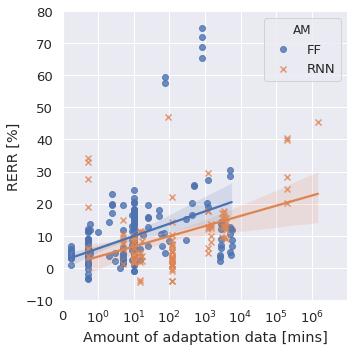

In [14]:
import seaborn as sns
import copy

sns.set(font_scale=1.2) 

#all datapoints
df_tmp = copy.deepcopy(df)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)
grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='AM', data=df_tmp, 
                   fit_reg=True, scatter=True,legend_out=False,
                  markers=['o', 'x'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid.savefig('/content/adaptminutes_AM.pdf')

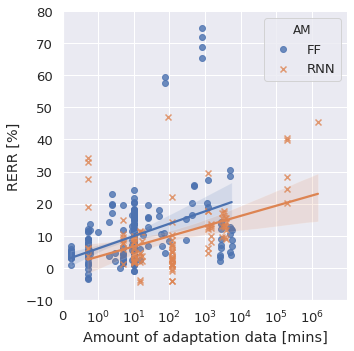

In [15]:
sns.set(font_scale=1.2) 

#all datapoints
df_tmp = copy.deepcopy(df)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)
grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='AM', data=df_tmp, 
                   fit_reg=True, scatter=True,legend_out=False,
                  markers=['o', 'x'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))


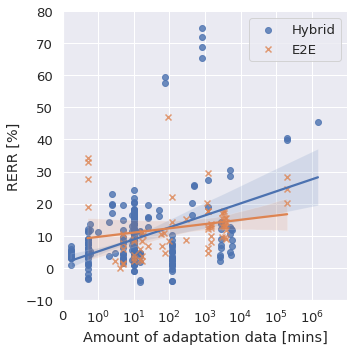

In [16]:
#all datapoints
df_tmp = copy.deepcopy(df)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)
grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='TLSystem', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('')
ax = grid.axes[0,0]
#ax.text(2.8, 68, "Fainberg's \n Cluster :)", horizontalalignment='right', size='small', color='black', weight='semibold')
grid.savefig('/content/adaptminutes_system.pdf')

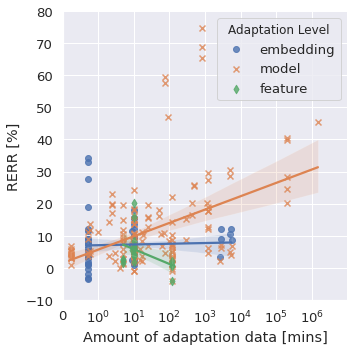

In [17]:
#single method datapoints
df_tmp = copy.deepcopy(df_sm)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)
grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='Level', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x', 'd'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('Adaptation Level')
grid.savefig('/content/adaptminutes_level.pdf')

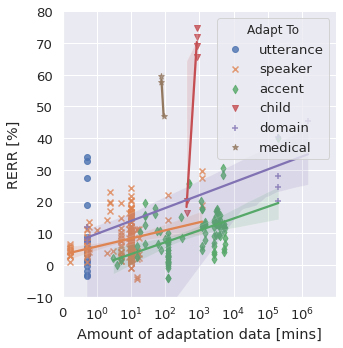

In [18]:
#all datapoints
df_tmp = copy.deepcopy(df)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)
grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='adapt_to', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x', 'd', 'v', '+', '*'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('Adapt To')
grid.savefig('/content/adaptminutes_clusters.pdf')

In [ ]:
#single method - note that when 2+ adapt are stacked, each method can operate in different regime
df_tmp = copy.deepcopy(df_sm)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)
grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='Unsup', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('')
grid.savefig('/content/adaptminutes_supervised.pdf')

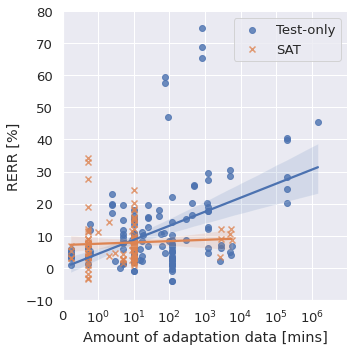

In [20]:
#single method
df_tmp = copy.deepcopy(df_sm)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)

grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='sat', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('')
grid.savefig('/content/adaptminutes_sat.pdf')

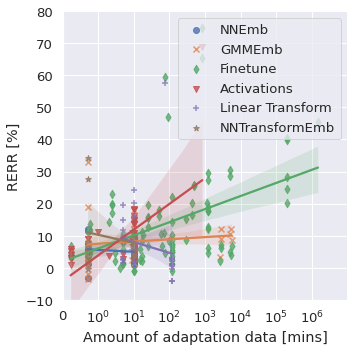

In [21]:

df_tmp = copy.deepcopy(df_sm) #it only makes sense to do this for single method
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)

grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='Family', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x', 'd', 'v', '+', '*'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('')
grid.savefig('/content/adaptminutes_family.pdf')

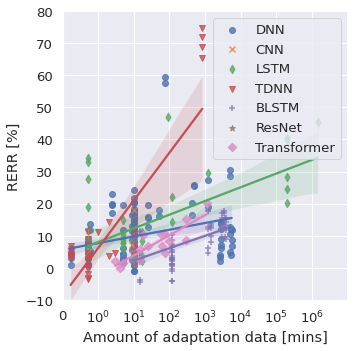

In [22]:

df_tmp = copy.deepcopy(df) #all methods
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)

grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='arch', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x', 'd', 'v', '+', '*', 'D'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('')
grid.savefig('/content/adaptminutes_arch.pdf')

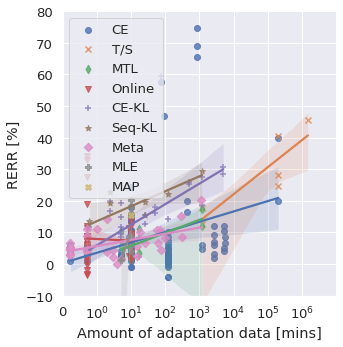

In [ ]:

df_tmp = copy.deepcopy(df_sm) #single method
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)

grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='Adapt Loss', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o', 'x', 'd', 'v', '+', '*', 'D', 'P', 'X'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(ylim=(-10, 80), xticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7], xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']))
grid._legend.set_title('')
grid._legend.texts[3].set_text('Online')
grid._legend.texts[4].set_text('CE-KL')
grid.savefig('/content/adaptminutes_adapt_loss.pdf')

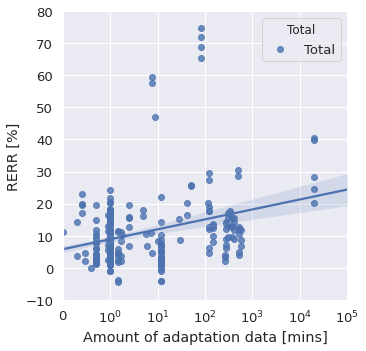

In [23]:
grid = sns.lmplot(x='Adapt minutes', y='WERR', hue='Total', data=df_tmp, fit_reg=True, scatter=True, legend_out=False, markers=['o'])
grid = (grid.set_axis_labels('Amount of adaptation data [mins]', 'RERR [%]')\
           .set(xlim=(0, 6), ylim=(-10, 80), xticklabels=['0', '$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']))
grid.savefig('/content/adaptminutes_total.pdf')

#Here some stuff related to adapt transform size


In [ ]:
sns.set(font_scale=1.2) 

df_tmp = copy.deepcopy(df)
df_tmp['#adapt_params'] = df_tmp['#adapt_params'].apply(np.log10)
grid = sns.lmplot(x='#adapt_params', y='WERR', hue='AM', data=df_tmp, 
                   fit_reg=True, scatter=True,legend_out=False,
                  markers=['o', 'x'])
grid = (grid.set_axis_labels('Parameters Adapted', 'RERR [%]')\
           .set(xlim=(1, 8), ylim=(-10, 80), xticklabels=['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$']))
grid.savefig('/content/adaptparams_AM.pdf')

In [ ]:
df_tmp = copy.deepcopy(df)
df_tmp['#adapt_params'] = df_tmp['#adapt_params'].apply(np.log10)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)

grid = sns.lmplot(x='#adapt_params', y='Adapt minutes', hue='TLSystem', data=df_tmp, 
                   fit_reg=True, scatter=True,legend_out=False,
                  markers=['o', 'x'])
#grid = (grid.set_axis_labels('Parameters Adapted', 'Adapt data')\
#           .set(xlim=(1, 8), ylim=(0, 6), xticklabels=['$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$']))
grid.savefig('/content/adaptparams_adaptminutes.pdf')

In [ ]:
df_tmp = copy.deepcopy(df.loc[:,['#adapt_params', 'Adapt minutes', 'WERR']])
df_tmp['#adapt_params'] = df_tmp['#adapt_params'].apply(np.log10)
df_tmp['Adapt minutes'] = df_tmp['Adapt minutes'].apply(np.log10)

#grid = sns.pairplot(df_tmp)

#grid = sns.lmplot(x='#adapt_params', y='WERR', hue='TLSystem', data=df_tmp, 
#                   fit_reg=True, scatter=True,legend_out=False,
#                  markers=['o', 'x'])
#grid = (grid.set_axis_labels('Size of adaptation transform', 'RERR [%]')\
#           .set(xlim=(1, 8), ylim=(-10, 80), xticklabels=['0', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$']))
#grid.savefig('/content/adaptparams_AM.pdf')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = df_tmp['#adapt_params']
ys = df_tmp['Adapt minutes']
zs = df_tmp['WERR']
ax.scatter(xs, ys, zs, s=100, alpha=0.6, edgecolors='w')

ax.set_xlabel('params')
ax.set_ylabel('data')
ax.set_zlabel('werr')

plt.show()


#sat vs. test-only top level

In [60]:
aggregate_all(dfd, ['sat'], fname_prefix='sat_vs_test', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
sat,,,,,,,,,,,,,
SAT,8.393295,6.307858,-4.55,34.13,7.51,3.730,12.100,587.034682,262.0,173,22,18,"chen2015improving,delcroix2018auxiliary,gupta2..."
Test-only,11.578683,13.833319,-4.08,74.74,6.64,3.665,15.075,1102.215569,300.0,167,30,25,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
sat,,,,,,,,,,,,,
SAT,7.731589,6.360576,-3.57,34.13,6.72,3.6750,9.125,811.261682,200.0,107,20,14,"chen2015improving,delcroix2018auxiliary,gupta2..."
Test-only,11.163750,13.272834,-4.08,74.74,6.52,3.6075,14.845,1140.850000,300.0,160,30,24,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
sat,,,,,,,,,,,,,
SAT,7.593673,6.580198,-3.57,34.13,6.21,3.5675,8.91,628.438776,140.0,98,19,13,"delcroix2018auxiliary,gupta2014vector,klejch20..."
Test-only,8.058824,6.311145,-0.93,29.50,5.93,3.6300,10.53,1568.541176,300.0,85,18,15,"abdel2013fast,huang2015regularized,huang2020ac..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
sat,,,,,,,,,,,,,
SAT,9.233333,2.878142,3.33,12.10,9.09,8.05,12.02,2802.000000,403.0,9,2,2,"chen2015improving,mana2019online"
Test-only,14.682667,17.597915,-4.08,74.74,7.41,3.01,18.76,656.133333,262.0,75,13,10,"Li2018Developing,chen2015improving,fainberg201..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
sat,,,,,,,,,,,,,
SAT,9.466061,6.117415,-4.55,21.78,11.23,4.0625,13.6225,223.515152,262.0,66,11,11,"chen2015improving,kitza2018comparison,miao2015..."
Test-only,21.062857,22.722797,8.50,72.03,13.64,9.9300,16.7050,219.142857,240.0,7,4,4,"fainberg2019acoustic,swietojanski2016different..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
sat,,,,,,,,,,,,,,,
SAT,11.9,6.663483,7.642353,4.420945,2.16,18.10,6.93,4.37,10.89,219.411765,300.0,17,7,6,"miao2015speaker,samarakoon2016factorized,saon2..."
Test-only,22.3,24.631975,18.636667,25.088502,3.62,68.96,9.60,5.33,14.50,215.666667,220.0,6,4,3,"fainberg2019acoustic,swietojanski2016different..."


In [61]:
aggregate_all(dfd, ['sat', 'AdaptBin'], fname_prefix='sat_vs_test_bins', plot_in_notebook=plot_in_notebook)


Plotting stats for all


werr  ...                                               refs
sat       AdaptBin             ...                                                   
SAT        1         7.754167  ...  gupta2014vector,klejch2019speaker,mana2019onli...
           10        7.817835  ...  delcroix2018auxiliary,klejch2019speaker,miao20...
           30        3.608750  ...                                kitza2018comparison
           6000     12.052813  ...                  chen2015improving,yi2016improving
Test-only -1        33.133333  ...                    Li2018Developing,meng2019domain
           1         5.110000  ...  abdel2013fast,huang2015regularized,klejch2018l...
           10        7.982836  ...  abdel2013fast,huang2015regularized,huang2020ac...
           30        9.494167  ...  huang2015regularized,meng2019speaker,winata202...
           60       12.862500  ...                  huang2014multi,winata2020learning
           600      10.660263  ...  huang2014multi,kim2017dysarthric,serizel2014de...
           6000     24.433636  ...  chen2015improving,fainberg2019acoustic,ghorban...

[11 rows x 13 columns]


Plotting stats for single_method


werr  ...                                               refs
sat       AdaptBin             ...                                                   
SAT        1         7.754167  ...  gupta2014vector,klejch2019speaker,mana2019onli...
           10        7.576462  ...  delcroix2018auxiliary,klejch2019speaker,miao20...
           6000      9.276667  ...                                  chen2015improving
Test-only -1        33.133333  ...                    Li2018Developing,meng2019domain
           1         5.110000  ...  abdel2013fast,huang2015regularized,klejch2018l...
           10        7.531803  ...  abdel2013fast,huang2015regularized,huang2020ac...
           30        9.494167  ...  huang2015regularized,meng2019speaker,winata202...
           60       12.862500  ...                  huang2014multi,winata2020learning
           600      10.660263  ...  huang2014multi,kim2017dysarthric,serizel2014de...
           6000     22.167143  ...  chen2015improving,fainberg2019acoustic,ghorban...

[10 rows x 13 columns]


Plotting stats for spk_adapt


werr  ...                                               refs
sat       AdaptBin             ...                                                   
SAT       1          7.627576  ...  gupta2014vector,klejch2019speaker,mana2019onli...
          10         7.576462  ...  delcroix2018auxiliary,klejch2019speaker,miao20...
Test-only 1          5.110000  ...  abdel2013fast,huang2015regularized,klejch2018l...
          10         7.855517  ...  abdel2013fast,huang2015regularized,huang2020ac...
          30         6.300000  ...                                    meng2019speaker
          600       18.200000  ...                                 weninger2019listen
          6000      25.266667  ...                                 weninger2019listen

[7 rows x 13 columns]


Plotting stats for domain_adapt


werr  ...                                               refs
sat       AdaptBin             ...                                                   
SAT        1         9.146667  ...                                     mana2019online
           6000      9.276667  ...                                  chen2015improving
Test-only -1        33.133333  ...                    Li2018Developing,meng2019domain
           10        1.273333  ...                                 winata2020learning
           30       11.091250  ...            huang2015regularized,winata2020learning
           60       12.862500  ...                  huang2014multi,winata2020learning
           600      10.241389  ...  huang2014multi,kim2017dysarthric,serizel2014de...
           6000     21.650556  ...  chen2015improving,fainberg2019acoustic,ghorban...

[8 rows x 13 columns]


Plotting stats for comp_methods


werr  ...                                               refs
sat       AdaptBin             ...                                                   
SAT       10         8.308125  ...  miao2015speaker,samarakoon2016factorized,saon2...
          30         3.608750  ...                                kitza2018comparison
          6000      12.693462  ...                  chen2015improving,yi2016improving
Test-only 10        12.568333  ...  swietojanski2016differentiable,swietojanski201...
          6000      72.030000  ...                               fainberg2019acoustic

[5 rows x 13 columns]


Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


werr  ...                                               refs
sat       AdaptBin          ...                                                   
SAT       10        11.900  ...  miao2015speaker,samarakoon2016factorized,saon2...
Test-only 10        12.354  ...  swietojanski2016differentiable,swietojanski201...
          6000      72.030  ...                               fainberg2019acoustic

[3 rows x 15 columns]

#hybrid vs. e2e

In [62]:
aggregate_all(dfd, ['TLSystem'], fname_prefix='hyb_e2e', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
TLSystem,,,,,,,,,,,,,
E2E,12.649385,8.809945,0.00,46.90,11.20,6.67,15.63,1290.230769,262.0,65,11,12,"delcroix2018auxiliary,ghorbani2018advancing,gh..."
Hybrid,9.321709,11.126719,-4.55,74.74,6.44,3.56,11.76,733.680000,262.0,275,35,29,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
TLSystem,,,,,,,,,,,,,
E2E,12.457333,10.452924,0.00,46.90,8.86,4.70,17.6100,1747.222222,1000.0,45,10,11,"delcroix2018auxiliary,ghorbani2018advancing,gh..."
Hybrid,9.247297,11.228063,-4.08,74.74,6.28,3.57,10.8075,859.081081,262.0,222,35,26,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
TLSystem,,,,,,,,,,,,,
E2E,12.811500,10.872827,1.20,34.13,8.655,3.935,19.7525,2639.750000,3400.0,20,5,7,"delcroix2018auxiliary,li2018speaker,meng2019sp..."
Hybrid,7.196012,5.413587,-3.57,27.50,5.880,3.620,8.9350,871.889571,200.0,163,28,20,"abdel2013fast,gupta2014vector,huang2015regular..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
TLSystem,,,,,,,,,,,,,
E2E,12.174000,10.321769,0.00,46.90,10.25,5.86,17.550,1033.200000,1000.0,25,5,4,"ghorbani2018advancing,ghorbani2018leveraging,m..."
Hybrid,14.914407,18.815299,-4.08,74.74,7.41,3.01,17.235,823.694915,262.0,59,9,8,"Li2018Developing,chen2015improving,fainberg201..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
TLSystem,,,,,,,,,,,,,
E2E,13.081500,2.850441,7.94,17.74,13.01,11.29,15.5175,262.000000,262.0,20,1,1,yi2016improving
Hybrid,9.633396,10.790439,-4.55,72.03,8.50,3.46,13.6400,208.415094,140.0,53,12,12,"chen2015improving,fainberg2019acoustic,kitza20..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
TLSystem,,,,,,,,,,,,,,,
Hybrid,14.613043,13.856028,10.510435,13.477144,2.16,68.96,6.93,4.49,11.78,218.434783,300.0,23,9,7,"fainberg2019acoustic,miao2015speaker,samarakoo..."


In [63]:
#hybrid vs. e2e wgen splitting on major archs
aggregate_all(dfd, ['System'], fname_prefix='hyb_e2e_cats', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
System,,,,,,,,,,,,,
E2E-AED,11.122800,8.577065,0.00,29.50,8.590,4.6000,15.2300,2464.000000,1000.0,25,4,4,"meng2019domain,meng2019speaker,weninger2019lis..."
E2E-AED-CTC,15.558889,13.092118,2.02,34.13,8.860,4.0800,27.5900,310.555556,207.0,9,2,4,"delcroix2018auxiliary,sari2020unsupervised"
E2E-CTC,11.907000,4.179043,1.20,17.74,12.725,9.4875,15.1975,648.000000,262.0,30,4,3,"ghorbani2018advancing,ghorbani2018leveraging,l..."
E2E-RNN-T,46.900000,NaN,46.90,46.90,46.900,46.9000,46.9000,30.000000,30.0,1,1,1,sim2019investigation
Hybrid,9.321709,11.126719,-4.55,74.74,6.440,3.5600,11.7600,733.680000,262.0,275,35,29,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
System,,,,,,,,,,,,,
E2E-AED,11.122800,8.577065,0.00,29.50,8.59,4.600,15.2300,2464.000000,1000.0,25,4,4,"meng2019domain,meng2019speaker,weninger2019lis..."
E2E-AED-CTC,15.558889,13.092118,2.02,34.13,8.86,4.080,27.5900,310.555556,207.0,9,2,4,"delcroix2018auxiliary,sari2020unsupervised"
E2E-CTC,9.558000,5.470378,1.20,17.61,9.05,5.845,12.5000,1420.000000,100.0,10,3,2,"ghorbani2018advancing,ghorbani2018leveraging,l..."
E2E-RNN-T,46.900000,NaN,46.90,46.90,46.90,46.900,46.9000,30.000000,30.0,1,1,1,sim2019investigation
Hybrid,9.247297,11.228063,-4.08,74.74,6.28,3.570,10.8075,859.081081,262.0,222,35,26,"Li2018Developing,abdel2013fast,chen2015improvi..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
System,,,,,,,,,,,,,
E2E-AED,13.014286,9.918069,2.10,29.50,11.20,5.95,18.200,5200.000000,3400.0,7,2,2,"meng2019speaker,weninger2019listen"
E2E-AED-CTC,15.558889,13.092118,2.02,34.13,8.86,4.08,27.590,310.555556,207.0,9,2,4,"delcroix2018auxiliary,sari2020unsupervised"
E2E-CTC,6.275000,3.898183,1.20,10.50,6.70,4.65,8.325,3400.000000,3400.0,4,1,1,li2018speaker
Hybrid,7.196012,5.413587,-3.57,27.50,5.88,3.62,8.935,871.889571,200.0,163,28,20,"abdel2013fast,gupta2014vector,huang2015regular..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
System,,,,,,,,,,,,,
E2E-AED,10.387222,8.191075,0.00,28.20,8.415,4.915,14.1225,1400.000000,1000.0,18,2,2,"meng2019domain,winata2020learning"
E2E-CTC,11.746667,5.511514,4.70,17.61,12.320,7.475,16.3325,100.000000,100.0,6,2,1,"ghorbani2018advancing,ghorbani2018leveraging"
E2E-RNN-T,46.900000,NaN,46.90,46.90,46.900,46.900,46.9000,30.000000,30.0,1,1,1,sim2019investigation
Hybrid,14.914407,18.815299,-4.08,74.74,7.410,3.010,17.2350,823.694915,262.0,59,9,8,"Li2018Developing,chen2015improving,fainberg201..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
System,,,,,,,,,,,,,
E2E-CTC,13.081500,2.850441,7.94,17.74,13.01,11.29,15.5175,262.000000,262.0,20,1,1,yi2016improving
Hybrid,9.633396,10.790439,-4.55,72.03,8.50,3.46,13.6400,208.415094,140.0,53,12,12,"chen2015improving,fainberg2019acoustic,kitza20..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
System,,,,,,,,,,,,,,,
Hybrid,14.613043,13.856028,10.510435,13.477144,2.16,68.96,6.93,4.49,11.78,218.434783,300.0,23,9,7,"fainberg2019acoustic,miao2015speaker,samarakoo..."


In [64]:
aggregate_all(dfd, ['TLSystem', 'AM'], fname_prefix='hyb_e2e_am_type', plot_in_notebook=plot_in_notebook)


Plotting stats for all


werr  ...                                               refs
TLSystem AM              ...                                                   
E2E      FF    7.598000  ...                                 winata2020learning
         RNN  14.164800  ...  delcroix2018auxiliary,ghorbani2018advancing,gh...
Hybrid   FF   10.199953  ...  abdel2013fast,chen2015improving,fainberg2019ac...
         RNN   6.174667  ...  Li2018Developing,huang2020acoustic,kitza2018co...

[4 rows x 13 columns]


Plotting stats for single_method


werr  ...                                               refs
TLSystem AM              ...                                                   
E2E      FF    7.598000  ...                                 winata2020learning
         RNN  14.887000  ...  delcroix2018auxiliary,ghorbani2018advancing,gh...
Hybrid   FF   10.034620  ...  abdel2013fast,chen2015improving,fainberg2019ac...
         RNN   6.607451  ...  Li2018Developing,huang2020acoustic,kitza2018co...

[4 rows x 13 columns]


Plotting stats for spk_adapt


werr  ...                                               refs
TLSystem AM              ...                                                   
E2E      RNN  12.811500  ...  delcroix2018auxiliary,li2018speaker,meng2019sp...
Hybrid   FF    7.418129  ...  abdel2013fast,gupta2014vector,huang2015regular...
         RNN   5.909583  ...  huang2020acoustic,kitza2018comparison,li2015mo...

[3 rows x 13 columns]


Plotting stats for domain_adapt


werr  ...                                               refs
TLSystem AM              ...                                                   
E2E      FF    7.598000  ...                                 winata2020learning
         RNN  19.038000  ...  ghorbani2018advancing,ghorbani2018leveraging,m...
Hybrid   FF   21.400000  ...  chen2015improving,fainberg2019acoustic,huang20...
         RNN   7.227778  ...                      Li2018Developing,zhu2019multi

[4 rows x 13 columns]


Plotting stats for comp_methods


werr  ...                                               refs
TLSystem AM              ...                                                   
E2E      RNN  13.081500  ...                                    yi2016improving
Hybrid   FF   10.842500  ...  chen2015improving,fainberg2019acoustic,miao201...
         RNN   3.722222  ...                 kitza2018comparison,tan2016speaker

[3 rows x 13 columns]


Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


werr  ...                                               refs
TLSystem AM              ...                                                   
Hybrid   FF   15.066818  ...  fainberg2019acoustic,miao2015speaker,samarakoo...
         RNN   4.630000  ...                                     tan2016speaker

[2 rows x 15 columns]

#embedding vs. features vd. model

In [65]:
aggregate_all(dfd, ['Level'], fname_prefix='emb_vs_feat_vs_mdl', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Level,,,,,,,,,,,,,
embedding,8.378110,6.251893,-3.57,34.13,7.940,3.625,12.0400,735.015748,262.0,127,18,16,"abdel2013fast,chen2015improving,delcroix2018au..."
feature,5.432500,5.245152,-4.08,20.17,4.185,2.300,6.5575,233.208333,262.0,24,11,9,"kitza2018comparison,miao2015speaker,samarakoon..."
model,11.594074,13.168254,-4.55,74.74,7.410,4.000,14.8600,987.740741,300.0,189,29,25,"Li2018Developing,chen2015improving,fainberg201..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Level,,,,,,,,,,,,,
embedding,7.166180,6.235844,-3.57,34.13,5.98,3.390,8.910,947.831461,300.0,89,17,14,"abdel2013fast,chen2015improving,delcroix2018au..."
feature,4.953158,5.474085,-4.08,20.17,3.73,1.920,6.230,214.789474,262.0,19,10,7,"kitza2018comparison,miao2015speaker,samarakoon..."
model,11.833836,13.162026,-4.08,74.74,7.41,4.065,15.215,1137.754717,300.0,159,29,23,"Li2018Developing,chen2015improving,fainberg201..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Level,,,,,,,,,,,,,
embedding,6.933625,6.475750,-3.57,34.13,5.875,3.2625,8.830,739.237500,207.0,80,16,13,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."
feature,6.343333,5.216049,1.36,20.17,5.500,3.1650,6.675,202.200000,200.0,15,9,6,"kitza2018comparison,miao2015speaker,samarakoon..."
model,8.856136,6.496515,-0.93,29.50,6.580,4.0750,12.280,1508.420455,300.0,88,17,14,"huang2015regularized,huang2020acoustic,kitza20..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Level,,,,,,,,,,,,,
embedding,9.233333,2.878142,3.33,12.10,9.09,8.0500,12.0200,2802.000000,403.0,9,2,2,"chen2015improving,mana2019online"
feature,-0.260000,2.632097,-4.08,1.94,0.55,-0.7125,1.0025,262.000000,262.0,4,1,1,zhu2019multi
model,15.524507,17.708987,-4.08,74.74,8.59,4.3150,19.8000,678.338028,400.0,71,13,10,"Li2018Developing,chen2015improving,fainberg201..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Level,,,,,,,,,,,,,
embedding,11.216579,5.367639,0.75,18.01,12.825,9.015,15.600,236.578947,262.0,38,6,6,"miao2015speaker,samarakoon2016factorized,saon2..."
feature,7.254000,4.255330,3.70,12.42,4.550,4.250,11.350,303.200000,300.0,5,3,3,"kitza2018comparison,saon2013speaker,woodland20..."
model,10.323333,13.352536,-4.55,72.03,7.755,3.540,13.425,192.666667,127.0,30,7,9,"chen2015improving,fainberg2019acoustic,kitza20..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Level,,,,,,,,,,,,,,,
embedding,11.405714,5.829061,7.139286,3.412034,2.16,13.66,6.405,4.585,8.8075,239.285714,300.0,14,5,4,"miao2015speaker,samarakoon2016factorized,saon2..."
model,19.602222,20.657962,15.754444,20.730375,2.42,68.96,10.890,4.610,14.8100,186.000000,140.0,9,4,4,"fainberg2019acoustic,swietojanski2016different..."


# mdl vs emb vd features hyb vs e2e

In [66]:
aggregate_all(dfd, ['Level', 'TLSystem'], fname_prefix='emb_vs_feat_vs_mdl_hyb_vs_e2e', plot_in_notebook=plot_in_notebook)


Plotting stats for all


werr  ...                                               refs
Level     TLSystem             ...                                                   
embedding E2E       13.850345  ...  delcroix2018auxiliary,sari2020unsupervised,yi2...
          Hybrid     6.758776  ...  abdel2013fast,chen2015improving,gupta2014vecto...
feature   Hybrid     5.432500  ...  kitza2018comparison,miao2015speaker,samarakoon...
model     E2E       11.681944  ...  ghorbani2018advancing,ghorbani2018leveraging,l...
          Hybrid    11.573399  ...  Li2018Developing,chen2015improving,fainberg201...

[5 rows x 13 columns]


Plotting stats for single_method


werr  ...                                               refs
Level     TLSystem             ...                                                   
embedding E2E       15.558889  ...         delcroix2018auxiliary,sari2020unsupervised
          Hybrid     6.222000  ...  abdel2013fast,chen2015improving,gupta2014vecto...
feature   Hybrid     4.953158  ...  kitza2018comparison,miao2015speaker,samarakoon...
model     E2E       11.681944  ...  ghorbani2018advancing,ghorbani2018leveraging,l...
          Hybrid    11.878293  ...  Li2018Developing,chen2015improving,fainberg201...

[5 rows x 13 columns]


Plotting stats for spk_adapt


werr  ...                                               refs
Level     TLSystem             ...                                                   
embedding E2E       15.558889  ...         delcroix2018auxiliary,sari2020unsupervised
          Hybrid     5.840282  ...  abdel2013fast,gupta2014vector,li2015modeling,m...
feature   Hybrid     6.343333  ...  kitza2018comparison,miao2015speaker,samarakoon...
model     E2E       10.563636  ...   li2018speaker,meng2019speaker,weninger2019listen
          Hybrid     8.612208  ...  huang2015regularized,huang2020acoustic,kitza20...

[5 rows x 13 columns]


Plotting stats for domain_adapt


werr  ...                                               refs
Level     TLSystem             ...                                                   
embedding Hybrid     9.233333  ...                   chen2015improving,mana2019online
feature   Hybrid    -0.260000  ...                                       zhu2019multi
model     E2E       12.174000  ...  ghorbani2018advancing,ghorbani2018leveraging,m...
          Hybrid    17.345435  ...  Li2018Developing,chen2015improving,fainberg201...

[4 rows x 13 columns]


Plotting stats for comp_methods


werr  ...                                               refs
Level     TLSystem             ...                                                   
embedding E2E       13.081500  ...                                    yi2016improving
          Hybrid     9.144444  ...  miao2015speaker,samarakoon2016factorized,saon2...
feature   Hybrid     7.254000  ...  kitza2018comparison,saon2013speaker,woodland20...
model     Hybrid    10.323333  ...  chen2015improving,fainberg2019acoustic,kitza20...

[4 rows x 13 columns]


Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Level,TLSystem,,,,,,,,,,,,,,,
embedding,Hybrid,11.405714,5.829061,7.139286,3.412034,2.16,13.66,6.405,4.585,8.8075,239.285714,300.0,14,5,4,"miao2015speaker,samarakoon2016factorized,saon2..."
model,Hybrid,19.602222,20.657962,15.754444,20.730375,2.42,68.96,10.890,4.610,14.8100,186.000000,140.0,9,4,4,"fainberg2019acoustic,swietojanski2016different..."


#supervised vs. unsupervised (yes means unsupervised)

In [67]:
aggregate_all(dfd, ['Unsup'], fname_prefix='sup_vs_unsup', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Unsup,,,,,,,,,,,,,
Supervised,13.234127,14.518405,-4.08,74.74,10.225,4.8425,15.425,927.309524,262.0,126,21,16,"Li2018Developing,chen2015improving,fainberg201..."
Unsupervised,8.028879,7.178158,-4.55,45.50,6.145,3.5075,11.055,788.719626,207.0,214,32,25,"Li2018Developing,abdel2013fast,delcroix2018aux..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Unsup,,,,,,,,,,,,,
Supervised,12.782222,15.194545,-4.08,74.74,8.24,4.015,15.675,1101.707071,400.0,99,20,16,"Li2018Developing,chen2015improving,fainberg201..."
Unsupervised,8.024048,7.348674,-3.57,45.50,6.00,3.565,9.450,954.000000,300.0,168,32,22,"Li2018Developing,abdel2013fast,delcroix2018aux..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Unsup,,,,,,,,,,,,,
Supervised,11.308400,7.341790,2.90,29.50,10.400,5.2600,14.3000,2769.640000,3000.0,25,8,6,"huang2020acoustic,klejch2018learning,klejch201..."
Unsupervised,7.256139,6.134135,-3.57,34.13,5.875,3.5075,8.8525,795.392405,300.0,158,30,21,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Unsup,,,,,,,,,,,,,
Supervised,13.280135,17.065296,-4.08,74.74,7.095,2.960,16.3675,538.216216,262.0,74,12,10,"Li2018Developing,chen2015improving,fainberg201..."
Unsupervised,20.157000,13.105182,7.31,45.50,15.645,12.245,23.4000,3460.000000,3400.0,10,4,3,"Li2018Developing,huang2015regularized,mana2019..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Unsup,,,,,,,,,,,,,
Supervised,14.891111,11.812623,4.00,72.03,13.010,11.6950,14.905,287.851852,262.0,27,3,3,"chen2015improving,fainberg2019acoustic,yi2016i..."
Unsupervised,8.046522,6.593780,-4.55,21.78,6.755,2.8975,12.855,185.086957,118.0,46,10,10,"kitza2018comparison,miao2015speaker,samarakoon..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Unsup,,,,,,,,,,,,,,,
Supervised,72.030000,NaN,68.960000,NaN,68.96,68.96,68.960,68.96,68.9600,114.000000,114.0,1,1,1,fainberg2019acoustic
Unsupervised,12.003182,6.083592,7.853636,4.494942,2.16,18.10,6.405,4.43,11.3475,223.181818,300.0,22,8,6,"miao2015speaker,samarakoon2016factorized,saon2..."


In [68]:
aggregate_all(dfd, ['Unsup', 'TLSystem'], fname_prefix='sup_vs_unsup_sys', plot_in_notebook=plot_in_notebook)


Plotting stats for all


werr  ...                                               refs
Unsup        TLSystem             ...                                                   
Supervised   E2E       12.644706  ...  ghorbani2018advancing,ghorbani2018leveraging,l...
             Hybrid    13.634933  ...  Li2018Developing,chen2015improving,fainberg201...
Unsupervised E2E       12.666429  ...  delcroix2018auxiliary,li2018speaker,meng2019do...
             Hybrid     7.704250  ...  Li2018Developing,abdel2013fast,gupta2014vector...

[4 rows x 13 columns]


Plotting stats for single_method


werr  ...                                               refs
Unsup        TLSystem             ...                                                   
Supervised   E2E       12.362903  ...  ghorbani2018advancing,ghorbani2018leveraging,l...
             Hybrid    12.973382  ...  Li2018Developing,chen2015improving,fainberg201...
Unsupervised E2E       12.666429  ...  delcroix2018auxiliary,li2018speaker,meng2019do...
             Hybrid     7.602013  ...  Li2018Developing,abdel2013fast,gupta2014vector...

[4 rows x 13 columns]


Plotting stats for spk_adapt


werr  ...                                               refs
Unsup        TLSystem             ...                                                   
Supervised   E2E       14.800000  ...   li2018speaker,meng2019speaker,weninger2019listen
             Hybrid     9.950556  ...  huang2020acoustic,klejch2018learning,klejch201...
Unsupervised E2E       11.740769  ...  delcroix2018auxiliary,li2018speaker,meng2019sp...
             Hybrid     6.854069  ...  abdel2013fast,gupta2014vector,huang2015regular...

[4 rows x 13 columns]


Plotting stats for domain_adapt


werr  ...                                               refs
Unsup        TLSystem             ...                                                   
Supervised   E2E       11.652083  ...  ghorbani2018advancing,ghorbani2018leveraging,m...
             Hybrid    14.061600  ...  Li2018Developing,chen2015improving,fainberg201...
Unsupervised E2E       24.700000  ...                                     meng2019domain
             Hybrid    19.652222  ...  Li2018Developing,huang2015regularized,mana2019...

[4 rows x 13 columns]


Plotting stats for comp_methods


werr  ...                                               refs
Unsup        TLSystem             ...                                                   
Supervised   E2E       13.081500  ...                                    yi2016improving
             Hybrid    20.061429  ...             chen2015improving,fainberg2019acoustic
Unsupervised Hybrid     8.046522  ...  kitza2018comparison,miao2015speaker,samarakoon...

[3 rows x 13 columns]


Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Unsup,TLSystem,,,,,,,,,,,,,,,
Supervised,Hybrid,72.030000,NaN,68.960000,NaN,68.96,68.96,68.960,68.96,68.9600,114.000000,114.0,1,1,1,fainberg2019acoustic
Unsupervised,Hybrid,12.003182,6.083592,7.853636,4.494942,2.16,18.10,6.405,4.43,11.3475,223.181818,300.0,22,8,6,"miao2015speaker,samarakoon2016factorized,saon2..."


# adapt mode 


In [69]:
aggregate_all(dfd, ['Adapt mode'], fname_prefix='adapt_mode', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt mode,,,,,,,,,,,,,
2pass,8.100886,5.898840,0.75,24.37,6.290,3.550,11.8850,201.303797,140.0,79,12,11,"abdel2013fast,kitza2018comparison,pan2020memor..."
enrol,12.016236,13.354421,-4.55,74.74,8.805,4.135,14.7925,1057.780899,331.0,178,25,19,"Li2018Developing,chen2015improving,fainberg201..."
online,7.311084,6.610567,-3.57,34.13,5.980,3.195,8.8850,981.192771,300.0,83,12,11,"delcroix2018auxiliary,gupta2014vector,li2015mo..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt mode,,,,,,,,,,,,,
2pass,8.161667,5.602132,1.36,24.37,6.445,3.8275,10.6750,214.611111,200.0,54,11,9,"abdel2013fast,kitza2018comparison,pan2020memor..."
enrol,11.943776,13.765566,-4.08,74.74,7.600,3.9750,15.2150,1256.286713,400.0,143,23,18,"Li2018Developing,chen2015improving,fainberg201..."
online,6.639857,6.574307,-3.57,34.13,5.850,3.0150,8.4725,1115.757143,207.0,70,12,11,"delcroix2018auxiliary,gupta2014vector,li2015mo..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt mode,,,,,,,,,,,,,
2pass,8.161667,5.602132,1.36,24.37,6.445,3.8275,10.675,214.611111,200.0,54,11,9,"abdel2013fast,kitza2018comparison,pan2020memor..."
enrol,8.888710,6.719022,-0.93,29.50,7.145,4.0250,11.500,2064.854839,1830.5,62,11,9,"huang2015regularized,huang2020acoustic,klejch2..."
online,6.527612,6.684907,-3.57,34.13,5.830,2.9600,8.465,825.417910,200.0,67,12,11,"delcroix2018auxiliary,gupta2014vector,li2015mo..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt mode,,,,,,,,,,,,,
enrol,14.282222,17.004494,-4.08,74.74,8.56,3.33,17.610,637.382716,400.0,81,13,10,"Li2018Developing,chen2015improving,fainberg201..."
online,9.146667,2.567145,7.31,12.08,8.05,7.68,10.065,7600.000000,7600.0,3,1,1,mana2019online



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt mode,,,,,,,,,,,,,
2pass,7.969600,6.614808,0.75,21.78,5.71,2.86,12.420,172.560000,100.0,25,6,8,"samarakoon2016factorized,saon2013speaker,swiet..."
enrol,12.312286,11.700639,-4.55,72.03,12.48,9.23,13.925,246.742857,262.0,35,4,4,"chen2015improving,fainberg2019acoustic,kitza20..."
online,10.925385,5.771503,1.02,18.01,11.88,8.50,15.690,256.615385,300.0,13,4,3,"miao2015speaker,saon2013speaker,tan2016speaker..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt mode,,,,,,,,,,,,,,,
2pass,13.560000,6.524707,8.745556,5.728658,2.42,18.10,5.88,4.61,13.57,174.888889,140.0,9,4,4,"samarakoon2016factorized,swietojanski2016diffe..."
enrol,72.030000,NaN,68.960000,NaN,68.96,68.96,68.96,68.96,68.96,114.000000,114.0,1,1,1,fainberg2019acoustic
online,10.925385,5.771503,7.236154,3.531264,2.16,13.66,6.93,4.37,8.91,256.615385,300.0,13,4,3,"miao2015speaker,saon2013speaker,tan2016speaker..."


# adapt mode - here we split also enrol on unsupervised/supervised 

In [70]:
aggregate_all(dfd, ['Adapt mode', 'Unsup'], fname_prefix='adapt_mode_sup', plot_in_notebook=plot_in_notebook)


Plotting stats for all


werr  ...                                               refs
Adapt mode Unsup                    ...                                                   
2pass      Unsupervised   8.100886  ...  abdel2013fast,kitza2018comparison,pan2020memor...
enrol      Supervised    13.234127  ...  Li2018Developing,chen2015improving,fainberg201...
           Unsupervised   9.065192  ...  Li2018Developing,huang2015regularized,huang202...
online     Unsupervised   7.311084  ...  delcroix2018auxiliary,gupta2014vector,li2015mo...

[4 rows x 13 columns]


Plotting stats for single_method


werr  ...                                               refs
Adapt mode Unsup                    ...                                                   
2pass      Unsupervised   8.161667  ...  abdel2013fast,kitza2018comparison,pan2020memor...
enrol      Supervised    12.782222  ...  Li2018Developing,chen2015improving,fainberg201...
           Unsupervised  10.057273  ...  Li2018Developing,huang2015regularized,huang202...
online     Unsupervised   6.639857  ...  delcroix2018auxiliary,gupta2014vector,li2015mo...

[4 rows x 13 columns]


Plotting stats for spk_adapt


werr  ...                                               refs
Adapt mode Unsup                    ...                                                   
2pass      Unsupervised   8.161667  ...  abdel2013fast,kitza2018comparison,pan2020memor...
enrol      Supervised    11.308400  ...  huang2020acoustic,klejch2018learning,klejch201...
           Unsupervised   7.253784  ...  huang2015regularized,huang2020acoustic,klejch2...
online     Unsupervised   6.527612  ...  delcroix2018auxiliary,gupta2014vector,li2015mo...

[4 rows x 13 columns]


Plotting stats for domain_adapt


werr  ...                                               refs
Adapt mode Unsup                    ...                                                   
enrol      Supervised    13.280135  ...  Li2018Developing,chen2015improving,fainberg201...
           Unsupervised  24.875714  ...  Li2018Developing,huang2015regularized,meng2019...
online     Unsupervised   9.146667  ...                                     mana2019online

[3 rows x 13 columns]


Plotting stats for comp_methods


werr  ...                                               refs
Adapt mode Unsup                    ...                                                   
2pass      Unsupervised   7.969600  ...  samarakoon2016factorized,saon2013speaker,swiet...
enrol      Supervised    14.891111  ...  chen2015improving,fainberg2019acoustic,yi2016i...
           Unsupervised   3.608750  ...                                kitza2018comparison
online     Unsupervised  10.925385  ...  miao2015speaker,saon2013speaker,tan2016speaker...

[4 rows x 13 columns]


Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt mode,Unsup,,,,,,,,,,,,,,,
2pass,Unsupervised,13.560000,6.524707,8.745556,5.728658,2.42,18.10,5.88,4.61,13.57,174.888889,140.0,9,4,4,"samarakoon2016factorized,swietojanski2016diffe..."
enrol,Supervised,72.030000,NaN,68.960000,NaN,68.96,68.96,68.96,68.96,68.96,114.000000,114.0,1,1,1,fainberg2019acoustic
online,Unsupervised,10.925385,5.771503,7.236154,3.531264,2.16,13.66,6.93,4.37,8.91,256.615385,300.0,13,4,3,"miao2015speaker,saon2013speaker,tan2016speaker..."


#type of AM (FF, RNN) then archs (CNN, DNN, LSTM, etc.)


In [71]:
aggregate_all(dfd, ['AM'], fname_prefix='am_type', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM,,,,,,,,,,,,,
FF,10.030261,11.196598,-3.57,74.74,7.07,3.8225,12.7700,716.565217,300.0,230,32,26,"abdel2013fast,chen2015improving,fainberg2019ac..."
RNN,9.806545,9.935462,-4.55,46.90,7.77,3.5325,12.9775,1098.336364,262.0,110,18,16,"Li2018Developing,delcroix2018auxiliary,ghorban..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM,,,,,,,,,,,,,
FF,9.838118,11.207818,-3.57,74.74,6.655,3.97,11.9775,831.870968,300.0,186,32,24,"abdel2013fast,chen2015improving,fainberg2019ac..."
RNN,9.673951,11.075960,-4.08,46.90,5.980,2.77,10.5000,1414.975309,262.0,81,17,15,"Li2018Developing,delcroix2018auxiliary,ghorban..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM,,,,,,,,,,,,,
FF,7.418129,5.68211,-3.57,27.50,5.880,3.595,9.7250,774.230216,200.0,139,26,19,"abdel2013fast,gupta2014vector,huang2015regular..."
RNN,9.046818,8.36861,1.20,34.13,7.055,3.795,9.6375,1983.977273,661.0,44,11,11,"delcroix2018auxiliary,huang2020acoustic,kitza2..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM,,,,,,,,,,,,,
FF,16.995106,18.392934,0.00,74.74,10.64,6.625,18.76,1002.340426,403.0,47,8,7,"chen2015improving,fainberg2019acoustic,huang20..."
RNN,10.419730,13.708089,-4.08,46.90,4.85,1.940,12.68,738.324324,262.0,37,6,4,"Li2018Developing,ghorbani2018advancing,ghorban..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM,,,,,,,,,,,,,
FF,10.842500,11.241129,0.75,72.03,10.35,3.70,14.5575,229.136364,220.0,44,10,11,"chen2015improving,fainberg2019acoustic,miao201..."
RNN,10.176897,5.794730,-4.55,17.74,11.72,7.94,13.5700,213.931034,262.0,29,3,3,"kitza2018comparison,tan2016speaker,yi2016impro..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM,,,,,,,,,,,,,,,
FF,15.066818,14.006084,10.89,13.66789,2.42,68.96,7.105,4.765,11.92,223.818182,300.0,22,8,6,"fainberg2019acoustic,miao2015speaker,samarakoo..."
RNN,4.630000,NaN,2.16,NaN,2.16,2.16,2.160,2.160,2.16,100.000000,100.0,1,1,1,tan2016speaker


In [72]:
aggregate_all(dfd, ['arch'], fname_prefix='am_arch', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
arch,,,,,,,,,,,,,
BLSTM,7.108571,5.815855,-4.55,17.74,6.795,2.6350,11.9000,468.457143,262.0,70,7,5,"ghorbani2018advancing,ghorbani2018leveraging,h..."
CNN,6.514667,4.026189,1.64,18.10,6.270,3.5950,8.4100,262.466667,100.0,15,4,7,"abdel2013fast,miao2015speaker,pan2020memory,sw..."
DNN,10.158089,8.686873,-0.93,59.52,7.840,4.2400,14.8600,745.331210,300.0,157,27,23,"abdel2013fast,chen2015improving,gupta2014vecto..."
LSTM,14.528000,13.420874,1.20,46.90,8.500,4.0625,22.7500,2200.625000,3400.0,40,11,11,"Li2018Developing,delcroix2018auxiliary,li2015m..."
ResNet,10.760000,1.708713,8.83,12.08,11.370,10.1000,11.7250,7600.000000,7600.0,3,1,1,mana2019online
TDNN,11.704250,20.195014,-3.57,74.74,5.545,3.3650,8.9225,151.400000,118.0,40,5,4,"fainberg2019acoustic,klejch2018learning,klejch..."
Transformer,7.598000,5.394495,0.00,20.18,6.670,3.5250,10.4450,1000.000000,1000.0,15,1,1,winata2020learning



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
arch,,,,,,,,,,,,,
BLSTM,4.930952,4.756544,-4.08,17.61,4.05,1.910,7.8150,635.428571,262.0,42,6,4,"ghorbani2018advancing,ghorbani2018leveraging,h..."
CNN,6.514667,4.026189,1.64,18.10,6.27,3.595,8.4100,262.466667,100.0,15,4,7,"abdel2013fast,miao2015speaker,pan2020memory,sw..."
DNN,10.289407,9.384569,-0.93,59.52,7.19,4.350,14.8475,917.364407,300.0,118,27,20,"abdel2013fast,chen2015improving,gupta2014vecto..."
LSTM,14.781795,13.498725,1.20,46.90,8.55,4.045,23.4000,2254.487179,3400.0,39,11,11,"Li2018Developing,delcroix2018auxiliary,li2015m..."
ResNet,10.760000,1.708713,8.83,12.08,11.37,10.100,11.7250,7600.000000,7600.0,3,1,1,mana2019online
TDNN,10.622000,18.790934,-3.57,74.74,5.26,3.470,8.9100,135.485714,118.0,35,5,4,"fainberg2019acoustic,klejch2018learning,klejch..."
Transformer,7.598000,5.394495,0.00,20.18,6.67,3.525,10.4450,1000.000000,1000.0,15,1,1,winata2020learning



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
arch,,,,,,,,,,,,,
BLSTM,5.605833,2.909850,1.90,9.93,4.900,3.6325,8.0250,1650.000000,1650.0,12,3,2,"huang2020acoustic,kitza2018comparison,pan2020m..."
CNN,6.514667,4.026189,1.64,18.10,6.270,3.5950,8.4100,262.466667,100.0,15,4,7,"abdel2013fast,miao2015speaker,pan2020memory,sw..."
DNN,8.341000,6.232881,-0.93,27.50,6.225,3.8275,12.0075,934.233333,300.0,90,23,17,"abdel2013fast,gupta2014vector,huang2015regular..."
LSTM,10.337188,9.372128,1.20,34.13,7.585,3.7950,11.9750,2109.218750,661.0,32,8,9,"delcroix2018auxiliary,li2015modeling,li2018spe..."
ResNet,10.100000,1.796051,8.83,11.37,10.100,9.4650,10.7350,7600.000000,7600.0,2,1,1,mana2019online
TDNN,5.078438,3.973110,-3.57,14.18,4.850,3.3650,7.3375,137.500000,118.0,32,4,3,"klejch2018learning,klejch2019speaker,rownicka2..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
arch,,,,,,,,,,,,,
BLSTM,4.661000,5.339579,-4.08,17.61,3.405,1.0725,6.9575,229.600000,262.0,30,3,2,"ghorbani2018advancing,ghorbani2018leveraging,z..."
DNN,16.552143,14.151017,2.00,59.52,12.420,7.2500,19.6550,863.142857,401.5,28,6,5,"chen2015improving,huang2014multi,huang2015regu..."
LSTM,35.100000,10.640332,20.10,46.90,39.900,26.4500,42.9500,2918.571429,3400.0,7,3,2,"Li2018Developing,meng2019domain,sim2019investi..."
ResNet,12.080000,NaN,12.08,12.08,12.080,12.0800,12.0800,7600.000000,7600.0,1,1,1,mana2019online
TDNN,69.753333,4.641135,65.56,74.74,68.960,67.2600,71.8500,114.000000,114.0,3,1,1,fainberg2019acoustic
Transformer,7.598000,5.394495,0.00,20.18,6.670,3.5250,10.4450,1000.000000,1000.0,15,1,1,winata2020learning



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
arch,,,,,,,,,,,,,
BLSTM,10.375000,5.800199,-4.55,17.74,12.10,8.735,13.7575,218.000000,262.0,28,2,2,"kitza2018comparison,yi2016improving"
DNN,9.760769,6.197702,0.75,21.78,10.80,3.890,14.9050,224.820513,200.0,39,9,10,"chen2015improving,miao2015speaker,samarakoon20..."
LSTM,4.630000,NaN,4.63,4.63,4.63,4.630,4.6300,100.000000,100.0,1,1,1,tan2016speaker
TDNN,19.280000,29.884689,1.02,72.03,9.90,1.570,11.8800,262.800000,300.0,5,2,2,"fainberg2019acoustic,xie2019"



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
arch,,,,,,,,,,,,,,,
DNN,13.827647,5.198200,8.419412,4.821835,2.42,18.10,5.88,4.61,12.06,212.352941,200.0,17,7,5,"miao2015speaker,samarakoon2016factorized,saon2..."
LSTM,4.630000,NaN,2.160000,NaN,2.16,2.16,2.16,2.16,2.16,100.000000,100.0,1,1,1,tan2016speaker
TDNN,19.280000,29.884689,19.290000,27.813978,4.37,68.96,7.28,6.93,8.91,262.800000,300.0,5,2,2,"fainberg2019acoustic,xie2019"


#adapt AMs trained with different objectives

In [73]:
aggregate_all(dfd, ['AM Loss'], fname_prefix='am_loss', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM Loss,,,,,,,,,,,,,
CE,9.801891,11.080209,-4.55,74.74,7.07,3.595,12.83,706.505455,262.0,275,40,29,"abdel2013fast,chen2015improving,delcroix2018au..."
Seq,10.617846,9.517693,0.00,45.50,8.10,4.250,13.64,1405.200000,400.0,65,12,13,"Li2018Developing,gupta2014vector,huang2015regu..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM Loss,,,,,,,,,,,,,
CE,9.360737,11.355426,-4.08,74.74,6.010,3.33,11.3700,836.327189,262.0,217,39,28,"abdel2013fast,chen2015improving,delcroix2018au..."
Seq,11.644000,10.091779,0.00,45.50,8.385,5.83,14.9975,1757.160000,1000.0,50,11,9,"Li2018Developing,gupta2014vector,huang2015regu..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM Loss,,,,,,,,,,,,,
CE,7.332941,6.237993,-3.57,34.13,5.87,3.39,9.4200,869.640523,200.0,153,29,20,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."
Seq,10.241333,7.019058,1.36,29.50,8.05,5.83,11.7675,2061.933333,400.0,30,9,7,"gupta2014vector,huang2015regularized,huang2020..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM Loss,,,,,,,,,,,,,
CE,14.208438,17.730085,-4.08,74.74,7.73,3.275,17.5650,756.6875,262.0,64,12,10,"chen2015improving,fainberg2019acoustic,ghorban..."
Seq,13.748000,13.404728,0.00,45.50,9.42,5.545,16.6425,1300.0000,1000.0,20,3,3,"Li2018Developing,huang2015regularized,winata20..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM Loss,,,,,,,,,,,,,
CE,11.452414,9.900160,-4.55,72.03,11.91,6.5225,15.1975,220.793103,262.0,58,12,11,"chen2015improving,fainberg2019acoustic,kitza20..."
Seq,7.197333,6.431121,0.99,21.78,4.25,1.8150,11.6150,232.000000,240.0,15,5,6,"samarakoon2016factorized,saon2013speaker,swiet..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM Loss,,,,,,,,,,,,,,,
CE,16.138235,15.303819,11.252941,15.653466,2.16,68.96,5.630,4.3500,13.570,199.058824,200.0,17,9,7,"fainberg2019acoustic,miao2015speaker,samarakoo..."
Seq,10.291667,8.060616,8.406667,2.811111,4.37,12.06,8.095,7.0175,10.395,273.333333,300.0,6,3,2,"saon2013speaker,swietojanski2016learning,xie2019"


#Seq seem to benefit more from adaptation, here we consider datasets that are the same for each

In [74]:
df_ce2seq = df_sm[(df_sm.ce2seq == 'yes')]
dfd_tmp = {}
dfd_tmp['ce2seq'] = df_ce2seq
aggregate_all(dfd_tmp, ['AM Loss'], fname_prefix='am_loss_ce2seq', plot_in_notebook=plot_in_notebook)


Plotting stats for ce2seq


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
AM Loss,,,,,,,,,,,,,
CE,10.350000,5.635599,2.90,22.96,9.675,5.7175,13.7075,305.000000,300.0,24,5,3,"huang2015regularized,pan2020memory,saon2013spe..."
Seq,9.736842,4.856239,4.24,19.50,8.910,6.1350,11.4750,314.736842,300.0,19,5,3,"huang2015regularized,pan2020memory,saon2013spe..."


#Adapt AMs with different objectives

In [75]:
aggregate_all(dfd, ['Adapt Loss'], fname_prefix='adapt_loss', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt Loss,,,,,,,,,,,,,
-,8.143269,7.470831,-3.57,34.13,7.245,3.6275,9.2250,1355.730769,253.5,52,11,10,"gupta2014vector,li2015modeling,mana2019online,..."
CE,9.321989,11.877978,-4.55,74.74,6.360,3.0025,12.1000,378.553763,262.0,186,27,23,"Li2018Developing,abdel2013fast,chen2015improvi..."
KL,14.787813,11.491830,1.20,59.52,12.295,7.8625,18.9675,2489.187500,3000.0,32,8,6,"huang2014multi,huang2015regularized,huang2020a..."
MAP,15.410000,NaN,15.41,15.41,15.410,15.4100,15.4100,81.000000,81.0,1,1,1,tomashenko2015gmm
MLE,9.876429,5.752326,1.36,20.17,7.680,5.9150,14.8275,178.214286,140.0,14,8,6,"miao2015speaker,samarakoon2016factorized,saon2..."
MTL,7.287000,5.222854,1.72,17.55,5.215,3.5875,11.0250,1420.000000,100.0,10,4,4,"ghorbani2018leveraging,li2018speaker,meng2019s..."
Meta,6.824516,4.473404,0.00,20.18,5.260,3.7300,9.6050,544.774194,118.0,31,3,2,"klejch2018learning,klejch2019speaker,winata202..."
Seq-KL,18.491250,7.244481,5.08,29.50,19.495,15.1250,22.3150,2200.000000,400.0,8,2,2,"huang2015regularized,weninger2019listen"
T/S,28.181667,12.754579,12.68,45.50,26.450,19.3825,37.3500,2300.000000,3400.0,6,3,2,"Li2018Developing,ghorbani2018advancing,meng201..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt Loss,,,,,,,,,,,,,
-,7.796800,7.405902,-3.57,34.13,7.125,3.6225,8.9100,1397.960000,207.0,50,11,10,"gupta2014vector,li2015modeling,mana2019online,..."
CE,8.675424,12.977801,-4.08,74.74,5.385,2.8250,8.6275,469.703390,262.0,118,25,20,"Li2018Developing,abdel2013fast,chen2015improvi..."
KL,14.787813,11.491830,1.20,59.52,12.295,7.8625,18.9675,2489.187500,3000.0,32,8,6,"huang2014multi,huang2015regularized,huang2020a..."
MAP,15.410000,NaN,15.41,15.41,15.410,15.4100,15.4100,81.000000,81.0,1,1,1,tomashenko2015gmm
MLE,9.541667,6.180426,1.36,20.17,6.675,5.7850,15.7025,157.916667,140.0,12,7,6,"miao2015speaker,samarakoon2016factorized,seide..."
MTL,7.582222,5.450456,1.72,17.55,5.800,3.5000,11.2000,1566.666667,100.0,9,4,4,"ghorbani2018leveraging,li2018speaker,meng2019s..."
Meta,6.824516,4.473404,0.00,20.18,5.260,3.7300,9.6050,544.774194,118.0,31,3,2,"klejch2018learning,klejch2019speaker,winata202..."
Seq-KL,18.491250,7.244481,5.08,29.50,19.495,15.1250,22.3150,2200.000000,400.0,8,2,2,"huang2015regularized,weninger2019listen"
T/S,28.181667,12.754579,12.68,45.50,26.450,19.3825,37.3500,2300.000000,3400.0,6,3,2,"Li2018Developing,ghorbani2018advancing,meng201..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt Loss,,,,,,,,,,,,,
-,7.710638,7.616524,-3.57,34.13,6.540,3.5850,8.9100,1002.085106,200.0,47,11,10,"gupta2014vector,li2015modeling,mana2019online,..."
CE,6.295070,4.843689,-0.93,24.37,5.230,2.9000,8.4700,519.028169,300.0,71,16,12,"abdel2013fast,delcroix2018auxiliary,kitza2018c..."
KL,10.468261,6.653073,1.20,27.50,8.400,5.9050,14.6250,3321.739130,3400.0,23,6,5,"huang2015regularized,huang2020acoustic,li2018s..."
MAP,15.410000,NaN,15.41,15.41,15.410,15.4100,15.4100,81.000000,81.0,1,1,1,tomashenko2015gmm
MLE,9.541667,6.180426,1.36,20.17,6.675,5.7850,15.7025,157.916667,140.0,12,7,6,"miao2015speaker,samarakoon2016factorized,seide..."
MTL,5.532857,3.867362,1.72,11.20,3.850,2.8300,8.1500,1985.714286,3400.0,7,3,3,"li2018speaker,meng2019speaker,tan2016speaker"
Meta,6.099375,3.420964,2.99,14.18,4.655,3.7300,7.2800,118.000000,118.0,16,2,1,"klejch2018learning,klejch2019speaker"
Seq-KL,18.805000,8.454702,5.08,29.50,20.795,15.1475,22.7450,2800.000000,400.0,6,2,2,"huang2015regularized,weninger2019listen"



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt Loss,,,,,,,,,,,,,
-,9.146667,2.567145,7.31,12.08,8.050,7.6800,10.0650,7600.000000,7600.0,3,1,1,mana2019online
CE,12.271277,19.254151,-4.08,74.74,5.540,2.5300,10.3800,395.191489,262.0,47,9,8,"Li2018Developing,chen2015improving,fainberg201..."
KL,25.826667,14.116834,12.74,59.52,25.410,16.1200,28.4900,361.555556,400.0,9,3,2,"huang2014multi,huang2015regularized,kim2017dys..."
MTL,14.755000,3.952727,11.96,17.55,14.755,13.3575,16.1525,100.000000,100.0,2,1,1,ghorbani2018leveraging
Meta,7.598000,5.394495,0.00,20.18,6.670,3.5250,10.4450,1000.000000,1000.0,15,1,1,winata2020learning
Seq-KL,17.550000,2.757716,15.60,19.50,17.550,16.5750,18.5250,400.000000,400.0,2,1,1,huang2015regularized
T/S,28.181667,12.754579,12.68,45.50,26.450,19.3825,37.3500,2300.000000,3400.0,6,3,2,"Li2018Developing,ghorbani2018advancing,meng201..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt Loss,,,,,,,,,,,,,
-,16.805000,1.704127,15.60,18.01,16.805,16.2025,17.4075,300.000000,300.0,2,1,1,saon2013speaker
CE,10.443971,9.666466,-4.55,72.03,10.955,4.1875,13.7825,220.382353,262.0,68,11,13,"chen2015improving,fainberg2019acoustic,kitza20..."
MLE,11.885000,0.756604,11.35,12.42,11.885,11.6175,12.1525,300.000000,300.0,2,1,1,saon2013speaker
MTL,4.630000,NaN,4.63,4.63,4.630,4.6300,4.6300,100.000000,100.0,1,1,1,tan2016speaker



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Adapt Loss,,,,,,,,,,,,,,,
-,16.805,1.704127,12.860,1.131371,12.06,13.66,12.860,12.46,13.2600,300.0,300.0,2,1,1,saon2013speaker
CE,14.893,14.707726,10.693,14.351266,2.42,68.96,6.405,4.55,11.0425,216.2,250.0,20,7,6,"fainberg2019acoustic,miao2015speaker,samarakoo..."
MTL,4.630,NaN,2.160,NaN,2.16,2.16,2.160,2.16,2.1600,100.0,100.0,1,1,1,tan2016speaker


#adapt to speaker, accent, domain, utterance, etc.

In [76]:
aggregate_all(dfd, ['adapt_to'], fname_prefix='adapt_clusters', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
adapt_to,,,,,,,,,,,,,
accent,9.767340,7.496146,-4.08,39.90,9.275,4.1725,13.5025,444.489362,262.0,94,9,6,"Li2018Developing,chen2015improving,ghorbani201..."
child,52.976667,27.071156,16.45,74.74,67.260,31.4800,71.2625,80.000000,114.0,6,2,2,"fainberg2019acoustic,serizel2014deep"
domain,23.292500,14.320767,7.31,45.50,22.400,11.0725,31.2500,4975.000000,3400.0,8,3,2,"Li2018Developing,mana2019online,meng2019domain"
medical,54.676667,6.802164,46.90,59.52,57.610,52.2550,58.5650,46.000000,54.0,3,2,2,"kim2017dysarthric,sim2019investigation"
speaker,7.809336,5.817454,-4.55,29.50,6.290,3.6650,11.0000,934.995261,300.0,211,29,23,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."
utterance,8.419444,11.884321,-3.57,34.13,4.020,1.0950,8.5000,341.277778,47.5,18,5,6,"abdel2013fast,rownicka2018analyzing,rownicka20..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
adapt_to,,,,,,,,,,,,,
accent,8.648529,8.358188,-4.08,39.90,6.625,2.7250,12.040,501.823529,400.0,68,8,6,"Li2018Developing,chen2015improving,ghorbani201..."
child,49.166000,28.410394,16.45,74.74,65.560,20.1200,68.960,73.200000,114.0,5,2,2,"fainberg2019acoustic,serizel2014deep"
domain,23.292500,14.320767,7.31,45.50,22.400,11.0725,31.250,4975.000000,3400.0,8,3,2,"Li2018Developing,mana2019online,meng2019domain"
medical,54.676667,6.802164,46.90,59.52,57.610,52.2550,58.565,46.000000,54.0,3,2,2,"kim2017dysarthric,sim2019investigation"
speaker,7.743212,5.602246,-0.93,29.50,6.270,3.7300,9.930,1144.060606,300.0,165,29,20,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."
utterance,8.419444,11.884321,-3.57,34.13,4.020,1.0950,8.500,341.277778,47.5,18,5,6,"abdel2013fast,rownicka2018analyzing,rownicka20..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
adapt_to,,,,,,,,,,,,,
speaker,7.743212,5.602246,-0.93,29.50,6.27,3.730,9.93,1144.060606,300.0,165,29,20,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."
utterance,8.419444,11.884321,-3.57,34.13,4.02,1.095,8.50,341.277778,47.5,18,5,6,"abdel2013fast,rownicka2018analyzing,rownicka20..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
adapt_to,,,,,,,,,,,,,
accent,8.648529,8.358188,-4.08,39.90,6.625,2.7250,12.040,501.823529,400.0,68,8,6,"Li2018Developing,chen2015improving,ghorbani201..."
child,49.166000,28.410394,16.45,74.74,65.560,20.1200,68.960,73.200000,114.0,5,2,2,"fainberg2019acoustic,serizel2014deep"
domain,23.292500,14.320767,7.31,45.50,22.400,11.0725,31.250,4975.000000,3400.0,8,3,2,"Li2018Developing,mana2019online,meng2019domain"
medical,54.676667,6.802164,46.90,59.52,57.610,52.2550,58.565,46.000000,54.0,3,2,2,"kim2017dysarthric,sim2019investigation"



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
adapt_to,,,,,,,,,,,,,
accent,12.693462,3.082635,4.00,17.74,12.945,11.6825,14.2925,294.538462,262.0,26,2,2,"chen2015improving,yi2016improving"
child,72.030000,NaN,72.03,72.03,72.030,72.0300,72.0300,114.000000,114.0,1,1,1,fainberg2019acoustic
speaker,8.046522,6.593780,-4.55,21.78,6.755,2.8975,12.8550,185.086957,118.0,46,10,10,"kitza2018comparison,miao2015speaker,samarakoon..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
adapt_to,,,,,,,,,,,,,,,
child,72.030000,NaN,68.960000,NaN,68.96,68.96,68.960,68.96,68.9600,114.000000,114.0,1,1,1,fainberg2019acoustic
speaker,12.003182,6.083592,7.853636,4.494942,2.16,18.10,6.405,4.43,11.3475,223.181818,300.0,22,8,6,"miao2015speaker,samarakoon2016factorized,saon2..."


# Speech style


In [77]:
aggregate_all(dfd, ['Style'], fname_prefix='speech_type', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Style,,,,,,,,,,,,,
Accented,8.180000,5.598171,-4.08,17.74,8.605,3.6075,12.7725,285.029412,262.0,68,5,3,"chen2015improving,ghorbani2018advancing,ghorba..."
Broadcast,4.096000,1.962409,1.36,7.72,3.830,2.7775,5.3300,305.600000,200.0,10,3,3,"gupta2014vector,woodland2015cambridge,zhang201..."
Child,52.976667,27.071156,16.45,74.74,67.260,31.4800,71.2625,80.000000,114.0,6,2,2,"fainberg2019acoustic,serizel2014deep"
Conversational,7.428889,4.061873,1.02,18.01,6.910,4.2350,9.2900,314.984127,300.0,63,10,3,"delcroix2018auxiliary,kitza2018comparison,li20..."
Dictation,14.445946,8.226203,1.20,30.58,13.700,7.6000,19.5000,3286.486486,1000.0,37,6,5,"huang2014multi,huang2015regularized,li2018spea..."
Lectures,9.606279,7.648186,0.97,34.13,6.440,4.1500,13.6050,130.604651,118.0,43,7,4,"delcroix2018auxiliary,klejch2018learning,klejc..."
Medical,54.676667,6.802164,46.90,59.52,57.610,52.2550,58.5650,46.000000,54.0,3,2,2,"kim2017dysarthric,sim2019investigation"
Meetings,4.370256,2.573918,0.75,8.83,4.000,2.1000,6.5900,546.153846,100.0,39,6,3,"huang2020acoustic,rownicka2019embeddings,samar..."
Read,10.122917,7.020301,0.00,27.59,9.310,5.4175,15.4650,645.875000,1000.0,24,4,3,"abdel2013fast,sari2020unsupervised,tomashenko2..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Style,,,,,,,,,,,,,
Accented,5.385952,4.950107,-4.08,17.61,4.845,2.1175,8.2725,279.142857,262.0,42,4,3,"chen2015improving,ghorbani2018advancing,ghorba..."
Broadcast,3.851429,2.198442,1.36,7.72,2.800,2.5950,4.9450,279.428571,200.0,7,3,2,"gupta2014vector,woodland2015cambridge,zhang201..."
Child,49.166000,28.410394,16.45,74.74,65.560,20.1200,68.9600,73.200000,114.0,5,2,2,"fainberg2019acoustic,serizel2014deep"
Conversational,6.474694,3.189900,1.04,14.86,5.880,4.0800,8.5300,319.265306,300.0,49,10,3,"delcroix2018auxiliary,kitza2018comparison,li20..."
Dictation,14.445946,8.226203,1.20,30.58,13.700,7.6000,19.5000,3286.486486,1000.0,37,6,5,"huang2014multi,huang2015regularized,li2018spea..."
Lectures,8.177222,7.451405,0.97,34.13,5.690,3.7300,10.9650,127.222222,118.0,36,7,3,"delcroix2018auxiliary,klejch2018learning,klejc..."
Medical,54.676667,6.802164,46.90,59.52,57.610,52.2550,58.5650,46.000000,54.0,3,2,2,"kim2017dysarthric,sim2019investigation"
Meetings,5.010385,2.585398,0.86,8.83,4.055,2.9625,7.3325,769.230769,100.0,26,5,3,"huang2020acoustic,rownicka2019embeddings,swiet..."
Read,10.122917,7.020301,0.00,27.59,9.310,5.4175,15.4650,645.875000,1000.0,24,4,3,"abdel2013fast,sari2020unsupervised,tomashenko2..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Style,,,,,,,,,,,,,
Broadcast,3.851429,2.198442,1.36,7.72,2.800,2.5950,4.9450,279.428571,200.0,7,3,2,"gupta2014vector,woodland2015cambridge,zhang201..."
Conversational,6.474694,3.189900,1.04,14.86,5.880,4.0800,8.5300,319.265306,300.0,49,10,3,"delcroix2018auxiliary,kitza2018comparison,li20..."
Dictation,12.460000,8.045738,1.20,29.50,10.935,5.8525,18.9725,3950.000000,3400.0,24,5,5,"huang2015regularized,li2018speaker,mana2019onl..."
Lectures,8.177222,7.451405,0.97,34.13,5.690,3.7300,10.9650,127.222222,118.0,36,7,3,"delcroix2018auxiliary,klejch2018learning,klejc..."
Meetings,5.010385,2.585398,0.86,8.83,4.055,2.9625,7.3325,769.230769,100.0,26,5,3,"huang2020acoustic,rownicka2019embeddings,swiet..."
Read,14.331111,7.674066,1.64,27.59,15.630,10.0300,18.1000,55.666667,81.0,9,3,2,"abdel2013fast,sari2020unsupervised,tomashenko2..."
Read-Noisy,7.057692,9.485145,-3.57,24.37,3.550,-0.2700,15.9700,14.000000,14.0,13,3,1,"rownicka2018analyzing,samarakoon2016factorized..."
VoiceSearch,7.396842,5.628202,-0.93,19.47,7.570,3.4150,10.8650,3013.157895,3400.0,19,4,3,"liao2013speaker,liu2016investigations,meng2019..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Style,,,,,,,,,,,,,
Accented,5.385952,4.950107,-4.08,17.61,4.845,2.1175,8.2725,279.142857,262.0,42,4,3,"chen2015improving,ghorbani2018advancing,ghorba..."
Child,49.166000,28.410394,16.45,74.74,65.560,20.1200,68.9600,73.200000,114.0,5,2,2,"fainberg2019acoustic,serizel2014deep"
Dictation,18.112308,7.515822,7.31,30.58,16.120,12.7400,25.4100,2061.538462,400.0,13,3,2,"huang2014multi,huang2015regularized,mana2019on..."
Medical,54.676667,6.802164,46.90,59.52,57.610,52.2550,58.5650,46.000000,54.0,3,2,2,"kim2017dysarthric,sim2019investigation"
Read,7.598000,5.394495,0.00,20.18,6.670,3.5250,10.4450,1000.000000,1000.0,15,1,1,winata2020learning
VoiceSearch,33.133333,10.167137,20.10,45.50,34.050,25.5750,40.2750,3400.000000,3400.0,6,2,1,"Li2018Developing,meng2019domain"



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Style,,,,,,,,,,,,,
Accented,12.693462,3.082635,4.00,17.74,12.945,11.6825,14.2925,294.538462,262.0,26,2,2,"chen2015improving,yi2016improving"
Broadcast,4.666667,1.460285,3.46,6.29,4.250,3.8550,5.2700,366.666667,200.0,3,2,2,"woodland2015cambridge,zhang2016dnn"
Child,72.030000,NaN,72.03,72.03,72.030,72.0300,72.0300,114.000000,114.0,1,1,1,fainberg2019acoustic
Conversational,10.768571,5.066797,1.02,18.01,11.075,8.6400,14.8050,300.000000,300.0,14,4,1,"saon2013speaker,swietojanski2016differentiable..."
Lectures,16.955714,3.210409,13.00,21.78,16.670,15.0700,18.5500,148.000000,140.0,7,3,3,"miao2015speaker,swietojanski2016differentiable..."
Meetings,3.090000,2.095300,0.75,7.22,2.860,1.1400,4.6300,100.000000,100.0,13,2,2,"samarakoon2016factorized,tan2016speaker"
Read-Noisy,5.168889,7.215067,-4.55,17.65,4.550,1.8500,11.1100,97.555556,108.0,9,2,2,"kitza2018comparison,samarakoon2016factorized"



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Style,,,,,,,,,,,,,,,
Broadcast,4.875000,2.001112,2.610000,0.268701,2.42,2.80,2.610,2.5150,2.7050,200.000000,200.0,2,1,1,zhang2016dnn
Child,72.030000,NaN,68.960000,NaN,68.96,68.96,68.960,68.9600,68.9600,114.000000,114.0,1,1,1,fainberg2019acoustic
Conversational,10.582500,5.479390,7.095833,3.189701,3.62,13.66,6.280,4.5500,8.6025,300.000000,300.0,12,4,1,"saon2013speaker,swietojanski2016differentiable..."
Lectures,17.508333,3.130945,12.395000,4.251281,5.50,18.10,12.535,11.0425,14.5000,132.666667,140.0,6,3,2,"miao2015speaker,swietojanski2016differentiable..."
Meetings,4.630000,NaN,2.160000,NaN,2.16,2.16,2.160,2.1600,2.1600,100.000000,100.0,1,1,1,tan2016speaker
Read-Noisy,17.650000,NaN,5.880000,NaN,5.88,5.88,5.880,5.8800,5.8800,14.000000,14.0,1,1,1,samarakoon2016factorized


#Language

In [78]:
aggregate_all(dfd, ['Language'], fname_prefix='lang', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Language,,,,,,,,,,,,,
English,10.224406,11.118710,-4.55,74.74,7.070,3.7300,13.6400,996.601533,300.0,261,37,26,"Li2018Developing,abdel2013fast,delcroix2018aux..."
French,6.705000,1.435427,5.69,7.72,6.705,6.1975,7.2125,478.000000,478.0,2,1,1,gupta2014vector
Italian,18.285000,2.595082,16.45,20.12,18.285,17.3675,19.2025,12.000000,12.0,2,1,1,serizel2014deep
Japanese,7.947500,2.711548,4.08,10.40,8.655,7.3575,9.2450,661.000000,661.0,4,2,1,"delcroix2018auxiliary,seki2018rapid"
Korean,58.565000,1.350574,57.61,59.52,58.565,58.0875,59.0425,54.000000,54.0,2,1,1,kim2017dysarthric
Mandarin,7.510290,5.373168,-4.08,17.74,7.120,3.1100,12.1000,315.681159,262.0,69,5,4,"chen2015improving,li2015modeling,pan2020memory..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Language,,,,,,,,,,,,,
English,10.403738,11.078291,-3.57,74.74,7.000,3.9625,13.6375,1175.163551,300.0,214,37,23,"Li2018Developing,abdel2013fast,delcroix2018aux..."
French,6.705000,1.435427,5.69,7.72,6.705,6.1975,7.2125,478.000000,478.0,2,1,1,gupta2014vector
Italian,18.285000,2.595082,16.45,20.12,18.285,17.3675,19.2025,12.000000,12.0,2,1,1,serizel2014deep
Japanese,7.947500,2.711548,4.08,10.40,8.655,7.3575,9.2450,661.000000,661.0,4,2,1,"delcroix2018auxiliary,seki2018rapid"
Korean,58.565000,1.350574,57.61,59.52,58.565,58.0875,59.0425,54.000000,54.0,2,1,1,kim2017dysarthric
Mandarin,4.376279,3.794776,-4.08,12.10,4.030,1.9700,6.8400,328.465116,262.0,43,4,4,"chen2015improving,li2015modeling,pan2020memory..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Language,,,,,,,,,,,,,
English,7.950176,6.626292,-3.57,34.13,6.000,3.5825,10.3825,1107.723529,300.0,170,29,18,"abdel2013fast,delcroix2018auxiliary,huang2015r..."
French,6.705000,1.435427,5.69,7.72,6.705,6.1975,7.2125,478.000000,478.0,2,1,1,gupta2014vector
Japanese,7.947500,2.711548,4.08,10.40,8.655,7.3575,9.2450,661.000000,661.0,4,2,1,"delcroix2018auxiliary,seki2018rapid"
Mandarin,4.635714,2.404855,1.04,8.33,4.170,3.3450,6.1100,428.571429,200.0,7,2,2,"li2015modeling,pan2020memory"



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Language,,,,,,,,,,,,,
English,19.883409,17.877718,0.00,74.74,15.415,7.8650,25.5250,1435.727273,1000.0,44,10,7,"Li2018Developing,fainberg2019acoustic,ghorbani..."
Italian,18.285000,2.595082,16.45,20.12,18.285,17.3675,19.2025,12.000000,12.0,2,1,1,serizel2014deep
Korean,58.565000,1.350574,57.61,59.52,58.565,58.0875,59.0425,54.000000,54.0,2,1,1,kim2017dysarthric
Mandarin,4.325833,4.033967,-4.08,12.10,3.865,1.7625,7.0825,309.000000,262.0,36,2,2,"chen2015improving,zhu2019multi"



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Language,,,,,,,,,,,,,
English,9.407872,11.385812,-4.55,72.03,7.220,2.9350,13.3200,183.574468,118.0,47,11,11,"fainberg2019acoustic,kitza2018comparison,miao2..."
Mandarin,12.693462,3.082635,4.00,17.74,12.945,11.6825,14.2925,294.538462,262.0,26,2,2,"chen2015improving,yi2016improving"



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Language,,,,,,,,,,,,,,,
English,14.613043,13.856028,10.510435,13.477144,2.16,68.96,6.93,4.49,11.78,218.434783,300.0,23,9,7,"fainberg2019acoustic,miao2015speaker,samarakoo..."


#Amounts of data AM was estimated from

In [44]:
#aggregate_all(dfd, ['#Hours'], fname_prefix=None, plot_in_notebook=plot_in_notebook)

# public (yes) vs. proprietary datasets (no)


In [79]:

aggregate_all(dfd, ['Public'], fname_prefix='corpora_public', plot_in_notebook=plot_in_notebook)



Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Public,,,,,,,,,,,,,
Proprietary,13.093158,11.986628,-0.93,59.52,9.54,4.56,16.535,2365.705263,1750.0,95,17,14,"Li2018Developing,chen2015improving,huang2014mu..."
Public,8.742163,10.055176,-4.55,74.74,6.52,3.53,11.500,248.510204,207.0,245,28,20,"abdel2013fast,delcroix2018auxiliary,fainberg20..."



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Public,,,,,,,,,,,,,
Proprietary,13.505233,12.455389,-0.93,59.52,9.315,4.7225,18.605,2572.372093,3000.0,86,17,13,"Li2018Developing,chen2015improving,huang2014mu..."
Public,8.022265,10.031950,-4.08,74.74,5.880,3.1100,8.910,265.839779,200.0,181,27,18,"abdel2013fast,delcroix2018auxiliary,fainberg20..."



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Public,,,,,,,,,,,,,
Proprietary,9.168846,7.206793,-0.93,29.50,7.775,4.000,12.3125,3250.961538,3000.0,52,11,9,"huang2015regularized,huang2020acoustic,li2018s..."
Public,7.270229,6.059071,-3.57,34.13,5.880,3.595,8.8850,197.427481,118.0,131,21,13,"abdel2013fast,delcroix2018auxiliary,gupta2014v..."



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Public,,,,,,,,,,,,,
Proprietary,20.137353,15.632599,2.00,59.52,15.645,8.1775,27.6175,1534.529412,403.0,34,8,6,"Li2018Developing,chen2015improving,huang2014mu..."
Public,9.992600,16.334762,-4.08,74.74,5.700,2.2775,10.5425,445.080000,262.0,50,6,5,"fainberg2019acoustic,ghorbani2018advancing,gho..."



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Public,,,,,,,,,,,,,
Proprietary,9.155556,4.542596,3.46,14.21,11.67,4.25,12.7800,390.888889,403.0,9,3,3,"chen2015improving,woodland2015cambridge,zhang2..."
Public,10.778125,9.916882,-4.55,72.03,11.23,4.55,15.5175,199.500000,262.0,64,10,10,"fainberg2019acoustic,kitza2018comparison,miao2..."



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Public,,,,,,,,,,,,,,,
Proprietary,4.875000,2.001112,2.610000,0.268701,2.42,2.80,2.61,2.515,2.705,200.000000,200.0,2,1,1,zhang2016dnn
Public,15.540476,14.163409,11.262857,13.890896,2.16,68.96,7.28,5.230,12.060,220.190476,300.0,21,8,6,"fainberg2019acoustic,miao2015speaker,samarakoo..."


# WERR across different datasets

In [80]:
#note, here we use unfiltered data (i.e. also when more than one adaptation is stacked)
aggregate_all(dfd, ['Train'], fname_prefix='datasets_perf', plot_in_notebook=plot_in_notebook)


Plotting stats for all


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Train,,,,,,,,,,,,,
AISHELL2,6.250000,2.941564,4.17,8.33,6.250,5.2100,7.2900,1000.0,1000.0,2,1,1,pan2020memory
AMI+PF-STAR,70.322500,3.956753,65.56,74.74,70.495,68.1100,72.7075,114.0,114.0,4,1,1,fainberg2019acoustic
AMI-IHM,4.640385,2.535551,0.86,8.83,4.320,2.3100,6.6150,100.0,100.0,26,5,1,"rownicka2019embeddings,samarakoon2016factorize..."
AMI-SDM,1.948571,1.142343,0.75,3.78,1.590,1.0600,2.7000,100.0,100.0,7,2,1,"samarakoon2016factorized,swietojanski2016learning"
Aurora4,7.814286,9.542611,-3.57,24.37,4.715,0.2100,17.2300,14.0,14.0,14,3,1,"rownicka2018analyzing,samarakoon2016factorized..."
CSJ,7.947500,2.711548,4.08,10.40,8.655,7.3575,9.2450,661.0,661.0,4,2,1,"delcroix2018auxiliary,seki2018rapid"
ChildIt+APASCI,18.285000,2.595082,16.45,20.12,18.285,17.3675,19.2025,12.0,12.0,2,1,1,serizel2014deep
Chime4,3.608750,5.870107,-4.55,11.36,4.125,0.4625,6.1900,108.0,108.0,8,1,1,kitza2018comparison
ETAPE,6.705000,1.435427,5.69,7.72,6.705,6.1975,7.2125,478.0,478.0,2,1,1,gupta2014vector



Plotting stats for single_method


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Train,,,,,,,,,,,,,
AISHELL2,6.250000,2.941564,4.17,8.33,6.250,5.2100,7.2900,1000.0,1000.0,2,1,1,pan2020memory
AMI+PF-STAR,69.753333,4.641135,65.56,74.74,68.960,67.2600,71.8500,114.0,114.0,3,1,1,fainberg2019acoustic
AMI-IHM,4.827895,2.683411,0.86,8.83,4.010,2.4600,6.8550,100.0,100.0,19,4,1,"rownicka2019embeddings,swietojanski2016differe..."
AMI-SDM,2.390000,NaN,2.39,2.39,2.390,2.3900,2.3900,100.0,100.0,1,1,1,swietojanski2016learning
Aurora4,7.057692,9.485145,-3.57,24.37,3.550,-0.2700,15.9700,14.0,14.0,13,3,1,"rownicka2018analyzing,samarakoon2016factorized..."
CSJ,7.947500,2.711548,4.08,10.40,8.655,7.3575,9.2450,661.0,661.0,4,2,1,"delcroix2018auxiliary,seki2018rapid"
ChildIt+APASCI,18.285000,2.595082,16.45,20.12,18.285,17.3675,19.2025,12.0,12.0,2,1,1,serizel2014deep
ETAPE,6.705000,1.435427,5.69,7.72,6.705,6.1975,7.2125,478.0,478.0,2,1,1,gupta2014vector
Google-ALS,46.900000,NaN,46.90,46.90,46.900,46.9000,46.9000,30.0,30.0,1,1,1,sim2019investigation



Plotting stats for spk_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Train,,,,,,,,,,,,,
AISHELL2,6.250000,2.941564,4.17,8.33,6.250,5.2100,7.2900,1000.0,1000.0,2,1,1,pan2020memory
AMI-IHM,4.827895,2.683411,0.86,8.83,4.010,2.4600,6.8550,100.0,100.0,19,4,1,"rownicka2019embeddings,swietojanski2016differe..."
AMI-SDM,2.390000,NaN,2.39,2.39,2.390,2.3900,2.3900,100.0,100.0,1,1,1,swietojanski2016learning
Aurora4,7.057692,9.485145,-3.57,24.37,3.550,-0.2700,15.9700,14.0,14.0,13,3,1,"rownicka2018analyzing,samarakoon2016factorized..."
CSJ,7.947500,2.711548,4.08,10.40,8.655,7.3575,9.2450,661.0,661.0,4,2,1,"delcroix2018auxiliary,seki2018rapid"
ETAPE,6.705000,1.435427,5.69,7.72,6.705,6.1975,7.2125,478.0,478.0,2,1,1,gupta2014vector
Google-Pers.,2.910000,1.826582,0.91,4.49,3.330,2.1200,3.9100,1750.0,1750.0,3,1,1,senior2014improving
Google-Search,5.821667,6.373095,-0.93,15.20,5.530,0.4600,9.5050,3000.0,3000.0,6,1,1,liao2013speaker
HKUST,3.990000,2.165098,1.04,6.29,3.630,3.0600,5.9300,200.0,200.0,5,1,1,li2015modeling



Plotting stats for domain_adapt


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Train,,,,,,,,,,,,,
AMI+PF-STAR,69.753333,4.641135,65.56,74.74,68.960,67.2600,71.8500,114.0,114.0,3,1,1,fainberg2019acoustic
ChildIt+APASCI,18.285000,2.595082,16.45,20.12,18.285,17.3675,19.2025,12.0,12.0,2,1,1,serizel2014deep
Google-ALS,46.900000,NaN,46.90,46.90,46.900,46.9000,46.9000,30.0,30.0,1,1,1,sim2019investigation
Intel Accented Mandarin Speech Recognition Corpus,7.198333,3.339033,2.00,12.10,6.840,4.7575,9.4575,403.0,403.0,12,1,1,chen2015improving
KoreanDisarthic,58.565000,1.350574,57.61,59.52,58.565,58.0875,59.0425,54.0,54.0,2,1,1,kim2017dysarthric
Librispeech,7.598000,5.394495,0.00,20.18,6.670,3.5250,10.4450,1000.0,1000.0,15,1,1,winata2020learning
MSFT-SMD,20.802000,6.246581,12.74,30.58,18.760,15.7975,25.7550,400.0,400.0,10,2,1,"huang2014multi,huang2015regularized"
MSFT-Speaker,33.133333,10.167137,20.10,45.50,34.050,25.5750,40.2750,3400.0,3400.0,6,2,1,"Li2018Developing,meng2019domain"
Nuance-CloseTalk,9.146667,2.567145,7.31,12.08,8.050,7.6800,10.0650,7600.0,7600.0,3,1,1,mana2019online



Plotting stats for comp_methods


,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Train,,,,,,,,,,,,,
AMI+PF-STAR,72.030000,NaN,72.03,72.03,72.030,72.0300,72.0300,114.0,114.0,1,1,1,fainberg2019acoustic
AMI-IHM,4.131429,2.184479,1.14,7.22,4.630,2.4500,5.5150,100.0,100.0,7,2,1,"samarakoon2016factorized,tan2016speaker"
AMI-SDM,1.875000,1.233073,0.75,3.78,1.360,1.0250,2.6550,100.0,100.0,6,1,1,samarakoon2016factorized
Aurora4,17.650000,NaN,17.65,17.65,17.650,17.6500,17.6500,14.0,14.0,1,1,1,samarakoon2016factorized
Chime4,3.608750,5.870107,-4.55,11.36,4.125,0.4625,6.1900,108.0,108.0,8,1,1,kitza2018comparison
Intel Accented Mandarin Speech Recognition Corpus,11.400000,3.745424,4.00,14.21,12.440,11.7775,13.4250,403.0,403.0,6,1,1,chen2015improving
MGB-200,4.875000,2.001112,3.46,6.29,4.875,4.1675,5.5825,200.0,200.0,2,1,1,zhang2016dnn
MGB-700,4.250000,NaN,4.25,4.25,4.250,4.2500,4.2500,700.0,700.0,1,1,1,woodland2015cambridge
RASC863+CASIA,13.081500,2.850441,7.94,17.74,13.010,11.2900,15.5175,262.0,262.0,20,1,1,yi2016improving



Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,werr,werr_std,ref_werr,ref_werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Train,,,,,,,,,,,,,,,
AMI+PF-STAR,72.0300,NaN,68.960000,NaN,68.96,68.96,68.96,68.960,68.9600,114.0,114.0,1,1,1,fainberg2019acoustic
AMI-IHM,4.6300,NaN,2.160000,NaN,2.16,2.16,2.16,2.160,2.1600,100.0,100.0,1,1,1,tan2016speaker
Aurora4,17.6500,NaN,5.880000,NaN,5.88,5.88,5.88,5.880,5.8800,14.0,14.0,1,1,1,samarakoon2016factorized
MGB-200,4.8750,2.001112,2.610000,0.268701,2.42,2.80,2.61,2.515,2.7050,200.0,200.0,2,1,1,zhang2016dnn
SWBD,10.5825,5.479390,7.095833,3.189701,3.62,13.66,6.28,4.550,8.6025,300.0,300.0,12,4,1,"saon2013speaker,swietojanski2016differentiable..."
TED,18.8875,2.586109,14.342500,2.991871,10.89,18.10,14.19,12.900,15.6325,140.0,140.0,4,2,1,"swietojanski2016differentiable,swietojanski201..."
TED-LIUM,14.7500,2.474874,8.500000,4.242641,5.50,11.50,8.50,7.000,10.0000,118.0,118.0,2,1,1,miao2015speaker


#finally, complimentarity. 

Note, here we somehwat need to better show that these are on top of existing ones already. This is perhaps not easy to do so in relative terms on independent plots. Need to draw stacked bar or so...

In [81]:
#need to do manual plotting based on dfd['comp_with_ref']
aggregate_all(dfd, ['Method1', 'Method2'], fname_prefix='complimentarity', plot_in_notebook=plot_in_notebook)


Plotting stats for all


werr  ...                                               refs
Method1     Method2              ...                                                   
BSV                    2.026000  ...                                     tan2016speaker
            ivectors   4.630000  ...                                     tan2016speaker
CNNEmb                 3.752000  ...  miao2015speaker,rownicka2018analyzing,rownicka...
DNNEmb                 5.513333  ...              miao2015speaker,rownicka2018analyzing
            LHUC      16.500000  ...                                    miao2015speaker
            fMLLR     13.000000  ...                                    miao2015speaker
DiffPooling            7.430000  ...                     swietojanski2016differentiable
            fMLLR     13.735000  ...                     swietojanski2016differentiable
FHL                    5.340000  ...                             ghorbani2018leveraging
FIL                    4.800000  ...                                    liao2013speaker
FLA                   12.123333  ...         huang2020acoustic,samarakoon2016factorized
            fMLLR      4.930000  ...                           samarakoon2016factorized
FOL                    5.800000  ...     chen2015improving,liao2013speaker,zhu2019multi
            ivectors  11.400000  ...                                  chen2015improving
Finetune              14.348690  ...  Li2018Developing,fainberg2019acoustic,ghorbani...
            fMLLR      3.200000  ...                                kitza2018comparison
GMMD                  16.380000  ...                                  tomashenko2015gmm
LHN                    6.434286  ...  kitza2018comparison,liu2016investigations,zhu2...
            fMLLR     11.235000  ...                                kitza2018comparison
LHUC                   9.616452  ...  fainberg2019acoustic,huang2020acoustic,klejch2...
            fMLLR     10.190000  ...  samarakoon2016factorized,swietojanski2016learning
LIN                    1.160000  ...  kitza2018comparison,seide2011feature,zhu2019multi
            fMLLR      4.125000  ...                                kitza2018comparison
LON                    9.707143  ...  kim2017dysarthric,kitza2018comparison,liu2016i...
            fMLLR     -4.125000  ...                                kitza2018comparison
LPT                    9.172500  ...            huang2020acoustic,liu2016investigations
OBN                    8.443333  ...                                     mana2019online
RNNEmb      FOL       15.267000  ...                                    yi2016improving
SNE                    5.282000  ...                              delcroix2018auxiliary
SincNet               65.560000  ...                               fainberg2019acoustic
            LHUC      72.030000  ...                               fainberg2019acoustic
SpkCodes               5.786667  ...                                      abdel2013fast
dvectors               3.533333  ...                                     li2015modeling
f-LHUC                 5.725833  ...                                            xie2019
            LHUC      12.480000  ...                                            xie2019
            ivectors   6.092500  ...                                            xie2019
fMLLR                  7.165833  ...  miao2015speaker,samarakoon2016factorized,seide...
            VTLN      11.885000  ...                                    saon2013speaker
            pRelu      4.250000  ...                              woodland2015cambridge
ivectors               7.325152  ...  chen2015improving,gupta2014vector,li2015modeli...
            FOL       10.896000  ...                                    yi2016improving
            LHUC      17.650000  ...                           samarakoon2016factorized
            fMLLR      6.421667  ...           samarakoon2016factorized,saon2013speaker
memory                12.068000  ...                 pan2020memory,


Plotting stats for single_method


,,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,Method2,,,,,,,,,,,,,
BSV,,2.026000,1.121865,0.86,3.85,1.720,1.5400,2.1600,100.000000,100.0,5,1,1,tan2016speaker
CNNEmb,,3.752000,5.054223,-3.08,7.51,7.180,-0.2700,7.4200,52.000000,14.0,5,3,3,"miao2015speaker,rownicka2018analyzing,rownicka..."
DNNEmb,,5.513333,5.257094,1.65,11.50,3.390,2.5200,7.4450,48.666667,14.0,3,2,2,"miao2015speaker,rownicka2018analyzing"
DiffPooling,,7.430000,5.174985,2.76,14.81,6.075,4.9125,8.5925,160.000000,120.0,4,1,3,swietojanski2016differentiable
FHL,,5.340000,0.905097,4.70,5.98,5.340,5.0200,5.6600,100.000000,100.0,2,1,1,ghorbani2018leveraging
FIL,,4.800000,8.103444,-0.93,10.53,4.800,1.9350,7.6650,3000.000000,3000.0,2,1,1,liao2013speaker
FLA,,12.123333,10.792851,4.00,24.37,8.000,6.0000,16.1850,2004.666667,3000.0,3,2,2,"huang2020acoustic,samarakoon2016factorized"
FOL,,5.800000,2.985309,-0.93,10.20,6.520,4.7575,7.1925,788.833333,403.0,12,3,3,"chen2015improving,liao2013speaker,zhu2019multi"
Finetune,,14.348690,13.361647,-1.02,74.74,10.995,4.8375,19.4925,1453.083333,400.0,84,21,16,"Li2018Developing,fainberg2019acoustic,ghorbani..."



Plotting stats for spk_adapt


,,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,Method2,,,,,,,,,,,,,
BSV,,2.026000,1.121865,0.86,3.85,1.720,1.5400,2.1600,100.000000,100.0,5,1,1,tan2016speaker
CNNEmb,,3.752000,5.054223,-3.08,7.51,7.180,-0.2700,7.4200,52.000000,14.0,5,3,3,"miao2015speaker,rownicka2018analyzing,rownicka..."
DNNEmb,,5.513333,5.257094,1.65,11.50,3.390,2.5200,7.4450,48.666667,14.0,3,2,2,"miao2015speaker,rownicka2018analyzing"
DiffPooling,,7.430000,5.174985,2.76,14.81,6.075,4.9125,8.5925,160.000000,120.0,4,1,3,swietojanski2016differentiable
FIL,,4.800000,8.103444,-0.93,10.53,4.800,1.9350,7.6650,3000.000000,3000.0,2,1,1,liao2013speaker
FLA,,12.123333,10.792851,4.00,24.37,8.000,6.0000,16.1850,2004.666667,3000.0,3,2,2,"huang2020acoustic,samarakoon2016factorized"
FOL,,2.750000,5.204306,-0.93,6.43,2.750,0.9100,4.5900,3000.000000,3000.0,2,1,1,liao2013speaker
Finetune,,10.530556,7.555378,1.20,29.50,8.475,4.4475,14.5250,2220.583333,400.0,36,10,8,"huang2015regularized,kitza2018comparison,klejc..."
GMMD,,16.380000,1.493620,15.41,18.10,15.630,15.5200,16.8650,81.000000,81.0,3,1,1,tomashenko2015gmm



Plotting stats for domain_adapt


,,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Method1,Method2,,,,,,,,,,,,,
FHL,,5.340000,0.905097,4.70,5.98,5.340,5.0200,5.6600,100.000000,100.0,2,1,1,ghorbani2018leveraging
FOL,,6.410000,2.324316,2.00,10.20,6.840,5.2525,7.3375,346.600000,403.0,10,2,2,"chen2015improving,zhu2019multi"
Finetune,,17.212292,15.913285,-1.02,74.74,13.985,5.7800,21.3100,877.458333,400.0,48,12,9,"Li2018Developing,fainberg2019acoustic,ghorbani..."
LHN,,2.067500,1.094726,1.02,3.11,2.070,1.1775,2.9600,262.000000,262.0,4,1,1,zhu2019multi
LHUC,,68.960000,NaN,68.96,68.96,68.960,68.9600,68.9600,114.000000,114.0,1,1,1,fainberg2019acoustic
LIN,,-0.260000,2.632097,-4.08,1.94,0.550,-0.7125,1.0025,262.000000,262.0,4,1,1,zhu2019multi
LON,,11.696000,25.817269,-4.08,57.61,2.590,-0.4100,2.7700,220.400000,262.0,5,2,2,"kim2017dysarthric,zhu2019multi"
OBN,,9.146667,2.567145,7.31,12.08,8.050,7.6800,10.0650,7600.000000,7600.0,3,1,1,mana2019online
SincNet,,65.560000,NaN,65.56,65.56,65.560,65.5600,65.5600,114.000000,114.0,1,1,1,fainberg2019acoustic



Plotting stats for comp_methods


werr  ...                                               refs
Method1     Method2              ...                                                   
BSV         ivectors   4.630000  ...                                     tan2016speaker
DNNEmb      LHUC      16.500000  ...                                    miao2015speaker
            fMLLR     13.000000  ...                                    miao2015speaker
DiffPooling fMLLR     13.735000  ...                     swietojanski2016differentiable
FLA         fMLLR      4.930000  ...                           samarakoon2016factorized
FOL         ivectors  11.400000  ...                                  chen2015improving
Finetune    fMLLR      3.200000  ...                                kitza2018comparison
LHN         fMLLR     11.235000  ...                                kitza2018comparison
LHUC        fMLLR     10.190000  ...  samarakoon2016factorized,swietojanski2016learning
LIN         fMLLR      4.125000  ...                                kitza2018comparison
LON         fMLLR     -4.125000  ...                                kitza2018comparison
RNNEmb      FOL       15.267000  ...                                    yi2016improving
SincNet     LHUC      72.030000  ...                               fainberg2019acoustic
f-LHUC      LHUC      12.480000  ...                                            xie2019
            ivectors   6.092500  ...                                            xie2019
fMLLR       VTLN      11.885000  ...                                    saon2013speaker
            pRelu      4.250000  ...                              woodland2015cambridge
ivectors    FOL       10.896000  ...                                    yi2016improving
            LHUC      17.650000  ...                           samarakoon2016factorized
            fMLLR      6.421667  ...           samarakoon2016factorized,saon2013speaker
pActivation fMLLR      4.875000  ...                                       zhang2016dnn

[21 rows x 13 columns]


Plotting stats for comp_with_ref RefWERR (complimentary)


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


werr  ...                            refs
Method1     Method2            ...                                
BSV         ivectors   4.6300  ...                  tan2016speaker
DNNEmb      LHUC      16.5000  ...                 miao2015speaker
            fMLLR     13.0000  ...                 miao2015speaker
DiffPooling fMLLR     13.7350  ...  swietojanski2016differentiable
LHUC        fMLLR     16.7925  ...        swietojanski2016learning
SincNet     LHUC      72.0300  ...            fainberg2019acoustic
f-LHUC      LHUC      12.4800  ...                         xie2019
            ivectors   6.0925  ...                         xie2019
ivectors    LHUC      17.6500  ...        samarakoon2016factorized
            fMLLR     16.8050  ...                 saon2013speaker
pActivation fMLLR      4.8750  ...                    zhang2016dnn

[11 rows x 15 columns]

In [82]:
stats = aggregate_stats(dfd['comp_with_ref'], ['Total'])
print_stats(stats)

,werr,werr_std,min,max,median,low_perc,high_perc,avg_hours,median_hours,n_points,n_studies,n_dsets,refs
Total,,,,,,,,,,,,,
Total,14.613043,13.856028,1.02,72.03,13.0,8.395,16.705,218.434783,300.0,23,9,7,"fainberg2019acoustic,miao2015speaker,samarakoo..."


In [ ]:
print (dfd['comp_with_ref'].to_string())

#Download the plots for overleaf

In [ ]:
!zip -r /content/figstex.zip /content/figs/*.tex
from google.colab import files
files.download("/content/figstex.zip")